# Functions + constant parameters

In [ ]:
Epi_Limiter = 1
a::Float32 = 1.0*Epi_Limiter   #Ratio of gene to epigenetic factor
v::Float32 = 6*10^-4/Epi_Limiter  #Speed at which epigenetic factor changes
#v::Float32 = 0  #Speed at which epigenetic factor changes









#Load_Generations = [70]
#Load_Generations = vcat(1,Load_Generations) #These are all the generations that we will analyse
Copies = [1] #Can reduce this to just 1,2 or just 1 if we don't want as many copies



#Main variables to change:
Stochastic_Noise = true
N::Int32 = 8 #How many copies of same network we have
#K::Int32 = N  Depricated parameter, do not change, if ever K not defined replace it by N
P = 4 #How many different networks will we use in the evolution run
Generations = 6 #How many generations in the evolution run

#DO NOT CHANGE THESE
Splits::Int32 = 6 #DO NOT CHANGE
SplitTime::Float32 = 0.1 #Time before a splitting event happens, DOES NOT MATTER HERE
M::Int32 = 40 #This is the amount of genes we want in our network
Splitting_Strength = 0.0f0

#CAREFUL WITH M>127 DO NOT INCREASE WITHOUT REWRITING DIFFERENTIATION FUNCTION
#BIT OVERFLOW!!!!!


#Constant and plotting tools


InvSqr::Float32 = 1/sqrt(M)
PCA_Plotting = false 
Orbit_Plotting = true  #Currently not used yet
Epi_Plotting = false #Currently not used yet
Counter = 0 #Used to randomise the mutations, leave to keep same seed
Saved_Generations = [2,4] #These are the generations where we want to save some orbits for


#Diffusion or mean field parameters
Mean_Field = false
Diffusing_System = false
KArray = zeros(Float32,M,1) #Diffusion/Mean Field array is set to zero everywhere
#KArray[1:10] .= 0.1 #Here we can manually adjust which genes will have diffusion

Amount_Large_Perturbations = 1 #How many large perturbations we will have each time
Amount_Small_Perturbations = 1 #How many smaller perturbations we will have around our large perturbation
Large_Pert_Radius = [0,1,5,20]
Small_Pert_Radius = 0
#Perturbations = zeros(32)



In [ ]:
using Random
using Plots
using Distributions
using DifferentialEquations
using Statistics
using ProgressMeter
using TickTock
using LinearAlgebra
using StatsBase
using LaTeXStrings
using MultivariateStats
using Dates
using Distances
using JLD
using KernelDensity
using Plots
using StatsPlots
using ForwardDiff 



function Setting_Up_Randomly(M,Sparse,rng=MersenneTwister(123))
    "Function used to randomly with seed define our c_i's, J_ij's and the initial positions
    Input:
    M      = Amount of Genes in our system
    Sparse = Bool to determine if we have a sparse graph
    rng    = Random Julia seed to make sure we can recreate the same initial conditions
    Output:
    CArray          = C_i's used, can only be between -0.5 and 0.5 now
    PositionArray   = Random Initial position, between -1 and 1 for all genes, epifactors = 0
    ParameterMatrix = J_ij's Currently a dense network with values between -0.5 and 0.5
    "
    ParameterMatrix = zeros(M,M)
    CArray = zeros(1,M)
    PositionArray = zeros(2,1,M)
    
    CArray = rand(rng,Float32,M).-0.5; #Random c_j between -0,5 and 0.5
    PositionArray[1,1,1:M] = 2*(rand(rng,Float32,M).-0.5); #Random Initial position 
    ParameterMatrix = 2 * bitrand(rng,M,M).-1; #J_jk's
    if Sparse
       for i=1:M
            for j=1:M
                if rand(rng) > 5/M #Average of 5 connections per gene

                    ParameterMatrix[i,j] = 0 
                end
            end
        end
    end
    return CArray, PositionArray, ParameterMatrix
end







function Noisy_Splitting(solution,Total_Splits,M,Seed)
    " Once our cell decides to split, we decide to introduce some random noise in how these genes get distributed.
    This function takes the cells, doubles them and then gives the daughters cell the same gene parameters +- noise
    one daughter gets + the other gets -. For the epigeneitc factors they are simply inherited and do not see any noise
    Input:
    solution     = These are the initial conditions of the parent cells that we need to split 
    (First genes of all cells, then all epigenetic factors)
    Total_Splits = Amount of times the cell has split (including this current split)
    M            = Amount of Genes
    Seed         = Random Noise seed for reproducing results
    Output:
    SplittedArray = New array of the genes and epigenetic factors of the daughter cells
    How is this structured? Suppose we take M=3 for convenience, we would have [g1,g2,g3,e1,e2,e3] for the first parent cell
    The daughters become: [g11,g12,g13,g21,g22,g23,e11,e12,e13,e21,e22,e23]
    Where we have genes of daughter 1, then genes of daughter 2, then epi of daughter 1 and epi of daughter 2.
    When the Daughters split we get the genes of Children of cell 1, then genes of Children of cell 2 and same for epi.
    "
    Random.seed!(Seed)
    s = Total_Splits #For shortening
    SplittedArray = zeros(Float32,2,2^(s),M) #2^(s+1), 2M is the normal length, 4M after 1 split, 8M after 2 splits etc.
    for g=1:2^(s-1) #looping over the length of the parent
        for t=1:M
            Gaussian = Normal{Float32}(0.0f0,0.0f0)
            Displace = rand(Gaussian) #Noise for split
            #index = Int32.(floor((g-1)/M)*M +g) #example M=10: Index 1-> 1 and 11, index 2->2 and 12 ... 
            #index 10->10 and 20, index 11->21 and 30 and so on. This is old method

            #Genes
            SplittedArray[1,2*g-1,t] = solution[1,g,t] + Displace
            SplittedArray[1,2*g,t] = solution[1,g,t] - Displace
            
        end
        #Epigenetic
        SplittedArray[2,2*g-1,:] = solution[2, g,:]
        SplittedArray[2,2*g,:] = solution[2, g,:]   
    end

    return SplittedArray  
end

function Differentiaton_Detection_Parameter(M,Epigenetic_Plot)
    "Function used to convert epigenetic factors into cell types and bits
    Input:
    M               = Amount of Genes 
    Epigenetic_Plot = Array of epigenetic factors which have to be converted to 0 and 1 representing on or off
    Output:
    b        = Array of scalar values representing cell types
    BitGenes = Array of vectors representing the genes of the cell types
    "
    b = Int128[]
    Counter = Int[]
    Epi_Bitwise = signbit.(-Epigenetic_Plot)

    
    BitGenes = [] #We will put the bit notation of the gene in here
    #Later rewrite to let this replace Bit_Represent
    
    for i=1:length(Epi_Bitwise[:,1])
        Bit_Represent::Int128 = 0 #CAREFUL WITH M>127
        for j=1:M
            Bit_Represent += Int128(Epi_Bitwise[i,j]*2)^(j-1)
        end
        #print(Bit_Represent)
        #print("     ")
        if !(Bit_Represent in b)

            push!(BitGenes,collect(Epi_Bitwise[i,:]))
            push!(Counter,1)
        end
        push!(b,Bit_Represent)

        
    end
    
    #print(b)
    Counter = sort(Counter,rev=true)
    #print(Counter)
    Score = 0
    #Make here the formula to turn b and the counter into a score


    return b,BitGenes
end

function Entropy_Score(M,Epigenetic_Plot)
    "Function used to convert epigenetic factors into cell types and bits to then calculate the entropic score.
    See previous function for alternative, this is currently not in use.
    Input:
    M               = Amount of Genes 
    Epigenetic_Plot = Array of epigenetic factors which have to be converted to 0 and 1 representing on or off
    Output:
    Score = Entropy score of the cell types
    "
    b = Int[]
    Counter = Int[]
    Epi_Bitwise = signbit.(-Epigenetic_Plot)
    
    for i=1:length(Epi_Bitwise[:,1])
        Bit_Represent::Int128 = 0 #CAREFUL WITH M>127
        for j=1:M
            Bit_Represent += Int128(Epi_Bitwise[i,j]*2)^(j-1)
        end
        #print(Bit_Represent)
        #print("     ")
        if !(Bit_Represent in b)
            push!(b,Bit_Represent)
            push!(Counter,1)
        else 
            Counter[findfirst(==(Bit_Represent), b)] += 1
        end
        
    end
    
    #print(b)
    Counter = sort(Counter,rev=true)
    #print(Counter)
    Score = 0
    #Make here the formula to turn b and the counter into a score
    for i=1:length(b)
       prob = Counter[i]/M
       Score -= prob*log(prob)
    end
    
    return Score
end



function Mutate_Parameters(ParameterMatrix_Mut,M,Mutations,Seed)
    "Function used to mutate the network (we turn a 1 or -1 to 0 and we turn a 0 to 1 or -1)
    Input:
    ParameterMatrix_Mut = Original Network that we want to mutate
    M                   = Amount of Genes 
    Mutations           = How many connections will we mutate
    Seed                = Randomness seed
    Output:
    ParameterMatrix_Mut = Mutated Network
    "
    Zero_Indices = findall(iszero,ParameterMatrix_Mut)
    One_Indices = findall(!iszero,ParameterMatrix_Mut)
    Random.seed!(Seed)
   
    for j=1:Mutations 
        t_zero = rand(1:length(Zero_Indices))
        t_one = rand(1:length(One_Indices))
        i_zero = Zero_Indices[t_zero][1]
        j_zero = Zero_Indices[t_zero][2]
        i_Value = One_Indices[t_one][1]
        j_Value = One_Indices[t_one][2]



        ParameterMatrix_Mut[i_zero,j_zero] = rand(0:1)*2-1 #turn a zero into 1 or -1
        ParameterMatrix_Mut[i_Value,j_Value] = 0 #turn 1 or -1 into 0




        
    end
    return ParameterMatrix_Mut
end


#Some Julia functions I played around with, may reconsider using more later
MultiplyBroad_(a,b) = a .* b

SummingDim2_(a) = sum(a,dims=2) 

HyperTanh_(a) = tanh.(40*a)



function Epigenetic_Evolution3(du,u,Parameters,Time)
    "Function used to define the ODE, needs to differentiate the boundaries and splits for diffusion.
    Input:
    du         = Used by ODESolver to calculate step, don't need to give input
    u          = These are our x's for the dx = f(x) solving. Basically the parameters that change
    Parameters = These are constants we have to give for our solver, it's a tuple consisting of J_ij's, C_i's, Diffusion, Splits
    Time       = This determines for how long the ODE will run
    Output is done through ODESolver, not this function
    "
    ParameterMatrix = Parameters[1]
    CArray = Parameters[2]
    KArray = Parameters[3]
    Splits = Parameters[4]
    
    #⊗_(Wi, bi) = Wi .* bi
       
    for t=1:2^Splits

        du[2,t,:] = v*(a*u[1,t,:].-u[2,t,:])    
        du[1,t,:] = tanh.(40*(InvSqr*ParameterMatrix*u[1,t,:].+u[2,t,:].+CArray[:])) .- u[1,t,:] 
            #Epigenetic Evolution, no need to worry about boundaries here so simple loop      
    end  
    
end



function Gradient(u,Splits,t)
    "Function used to calculate the gradient of a cells neighbours, takes into accounts if there even are neighbours.
    Input:
    u      = Gene concentrations over which we take the gradient
    Splits = How many times have the cells split already (determines where neighbours are)
    t      = What location is our cell (boundaries only have 1 neighbour)
    Output:
    Multiple different version depending on the splits, this will be the gradient we want
    "
    if Splits == 0
        return 0
    elseif Splits ==1
        if t==1
            return u[t+1,:] - u[t,:]
        else
            return u[t-1,:] - u[t,:]
        end
    else
        if t==1
            return u[t+1,:] - u[t,:]
        elseif t==2^Splits
            return u[t-1,:] - u[t,:]
        else
            return u[t-1,:] - 2*u[t,:] + u[t+1,:]
        end
    end
    
end

function Epigenetic_Evolution4(du,u,Parameters,Time)
    "Function used to define the ODE, needs to differentiate the boundaries and splits for diffusion.
    Input:
    du         = Used by ODESolver to calculate step, don't need to give input
    u          = These are our x's for the dx = f(x) solving. Basically the parameters that change
    Parameters = These are constants we have to give for our solver, it's a tuple consisting of J_ij's, C_i's, Diffusion, Splits
    Time       = This determines for how long the ODE will run
    Output is done through ODESolver, not this function
    "
    ParameterMatrix = Parameters[1]
    CArray = Parameters[2]
    KArray = Parameters[3]
    Splits = Parameters[4]
    
    #⊗_(Wi, bi) = Wi .* bi
       
    for t=1:2^Splits

        du[2,t,:] = v*(a*u[1,t,:].-u[2,t,:])    
        du[1,t,:] = tanh.(40*(InvSqr*ParameterMatrix*u[1,t,:].+u[2,t,:].+CArray[:])) .- u[1,t,:] +KArray.*Gradient(u[1,:,:],Splits,t)
            #Epigenetic Evolution, no need to worry about boundaries here so simple loop      
    end  
    
end

function σ_Genes(du, u,Parameters,Time)
    du[1,:,:] .= Noise
    
end



function Epigenetic_Evolution2(du,u,Parameters,Time)
    "Function used to define the ODE, needs to differentiate the boundaries and splits for diffusion.
    Input:
    du         = Used by ODESolver to calculate step, don't need to give input
    u          = These are our x's for the dx = f(x) solving. Basically the parameters that change
    Parameters = These are constants we have to give for our solver, it's a tuple consisting of J_ij's, C_i's, Diffusion, Splits
    Time       = This determines for how long the ODE will run
    Output is done through ODESolver, not this function
    "
    ParameterMatrix = Parameters[1]
    CArray = Parameters[2]
    KArray = Parameters[3]
    Splits = Parameters[4]
    Cells::Int32 = 2^Splits
    #⊗_(Wi, bi) = Wi .* bi
       
    for t=1:Cells  

       du[2,t,:] = v*(a*u[1,t,:].-u[2,t,:])    

       du[1,t,:] = tanh.(40*(InvSqr*ParameterMatrix*u[1,t,:].+u[2,t,:].+CArray[:])) .- u[1,t,:] .+ KArray.*(vec(sum(u[1,:,:],dims=1))/Cells - u[1,t,:])

    end  
    
end

#Defining it all in function form


function Mutating_Network(N,M,K,ParameterMatrix_Collection,PositionArray_Collection, Indices, Counter, Genetics)
    "Function used to make mutated copies of the best performing networks. Currently not in use
    Input:
    N                          = How many copies of the network do we make
    M                          = Amount of Genes
    K                          = Supposed to work as a fraction of N, telling us how many mutant versions
    ParameterMatrix_Collection = The original networks
    PositionArray_Collection   = Original Positions
    Indices                    = Sorted indices giving the best networks
    Counter                    = Randomiser seed
    Genetics                   = Used to track heritance of networks
    Output:
    ParameterMatrix_Collection = Updated network
    PositionArray_Collection   = Updated initial positions
    Counter                    = Updated seed
    Updated_Genes              = Updated inheritance
    "
    Updated_Genes = zeros(N)
    Mutations = 1
    Seed_Mutations = 1234
    Indexation_Mutate = 1
    Temporary_Matrix = zeros(Float32,N,M,M)
    Temporary_Vector = zeros(Float32,N,2,1,M)
    for p = 1:K
        for q=1:N/(2*K)
            Temporary_Matrix[Indexation_Mutate,:,:] = Mutate_Parameters(ParameterMatrix_Collection[Indices[p],:,:],M,Mutations,Seed_Mutations+Counter)
            Temporary_Vector[Indexation_Mutate,:,:,:] = PositionArray_Collection[Indices[p],:,:,:]
            Updated_Genes[Indexation_Mutate] = Genetics[p]
            Temporary_Matrix[Indexation_Mutate+1,:,:] = Temporary_Matrix[Indexation_Mutate,:,:]
            Temporary_Vector[Indexation_Mutate+1,:,:,:] = Temporary_Vector[Indexation_Mutate,:,:,:]
            Updated_Genes[Indexation_Mutate+1] = Genetics[p]
            Counter += 1
            Indexation_Mutate +=2
        end
        Temporary_Matrix[Indexation_Mutate-1,:,:] = ParameterMatrix_Collection[Indices[p],:,:] #We overwrite it to add the original back
        Temporary_Matrix[Indexation_Mutate-2,:,:] = ParameterMatrix_Collection[Indices[p],:,:]
    end
    ParameterMatrix_Collection = deepcopy(Temporary_Matrix);
    PositionArray_Collection = deepcopy(Temporary_Vector);
    return ParameterMatrix_Collection, PositionArray_Collection, Counter, Updated_Genes
end



function Running_Network(CArray,ParameterMatrix,PositionArray,Random_Noise)
    "Function used to run our simulation
    Input:
    CArray          = Constants used in our ODE solver  
    ParameterMatrix = Collection of Networks
    PositionArray   = Original Positions
    Random_Noise    = Randomiser seed
    Output:
    PositionArray[2,:,:] = Epigenetic factors from our simulation
    Random_Noise         = Updated seed
    "
    #CArray = CArray_Collection[x,:]
    #ParameterMatrix = ParameterMatrix_Collection[x,:,:]
    #PositionArray = PositionArray_Collection[x,:]
    Orbit_Collection = zeros(Float32,2^Splits*M+1,0)
    Epi_Collection = zeros(Float32,2^Splits*M+1,0)
    
    
    
    
    for s=1:Splits #Looping over the splits
        Parameters = (ParameterMatrix, CArray,KArray,Int32(s-1)) #We have to update the splits every rerun, rest stays same
        tspan = (Float32(0.0),SplitTime) #How long ODE will run
        if Mean_Field
            prob = ODEProblem(Epigenetic_Evolution2,PositionArray,tspan,Parameters) #ODEdefining
        elseif Diffusing_System
            prob = ODEProblem(Epigenetic_Evolution4,PositionArray,tspan,Parameters) #ODEdefining
        elseif Stochastic_Noise
            prob = SDEProblem(Epigenetic_Evolution4, σ_Genes,PositionArray,tspan,Parameters)

        else
            prob = ODEProblem(Epigenetic_Evolution3,PositionArray,tspan,Parameters) #ODEdefining
        end    #Solving
        if !Stochastic_Noise
            sol = solve(prob,BS3())
        else
            sol = solve(prob,SRA3())
            #sol = solve(prob,LambaEulerHeun())
        end
        Times = sol.t #Save the time, doesn't get used yet though
        StepAmount = length(Times)  #Amount of data points per gene
        Genes = sol 
        PositionArray = Genes[StepAmount] #Saving the genes and epi factors
        
        OrbitalCollection = Times' .+ (s-1)*SplitTime
        EpiCollected = Times' .+ (s-1)*SplitTime
        for i=1:2^(Splits-s+1)  #s=1 this gives all 2^Splits, this is to say how much we repeat same path
            for j=1:2^(s-1) #Together multiply, always 2^Splits orbits, these j represent different paths
                OrbitalCollection = vcat(OrbitalCollection,sol[1,j,:,:])   
                EpiCollected = vcat(EpiCollected,sol[2,j,:,:])   
            end
        end
        Orbit_Collection = hcat(Orbit_Collection,OrbitalCollection)
        Epi_Collection = hcat(Epi_Collection,EpiCollected)
        #Orbit1 = [Times,Genes[1,1,1:M,1:StepAmount]]
        #Orbit2 = [Times,Genes[1,1,1:M,1:StepAmount]]
        #EpiOrbit1 = [Times,Genes[2,1,1:M,1:StepAmount]]
        #EpiOrbit2 = [Times,Genes[2,1,1:M,1:StepAmount]]
        #Now we must take all the values from the updated PositionArray and give appropriate terms to the daughter cells
        PositionArray = Noisy_Splitting(PositionArray,s,M,Random_Noise)  #Splitting function
        Random_Noise += 1
    end

    Final_Run_Time::Int32 = 20000 #Long evolving of the cells after splitting to get the final epigenetic state
    Parameters = (ParameterMatrix, CArray,KArray,Int32(Splits)) 
    tspan = (Int32(0.0),Final_Run_Time)

    if Mean_Field
        prob = ODEProblem(Epigenetic_Evolution2,PositionArray,tspan,Parameters) #ODEdefining
    elseif Diffusing_System
        prob = ODEProblem(Epigenetic_Evolution4,PositionArray,tspan,Parameters) #ODEdefining
    elseif Stochastic_Noise
        prob = SDEProblem(Epigenetic_Evolution4, σ_Genes,PositionArray,tspan,Parameters)

    else
        prob = ODEProblem(Epigenetic_Evolution3,PositionArray,tspan,Parameters) #ODEdefining
    end    #Solving
    if !Stochastic_Noise
        sol = solve(prob,BS3())
    else
        #,dtmin=0.1,force_dtmin=true
        sol = solve(prob,SRA3(),dtmin=0.1,force_dtmin=true)
    end
    #sol = solve(prob,alg_hints = [:nonstiff]) #Solving
    #sol = solve(prob)
    Times = sol.t
    StepAmount = length(Times)
    GenesEpi = sol
    PositionArray = GenesEpi[StepAmount]

    OrbitalCollection = Times' .+ Splits*SplitTime 
    EpiCollected = Times' .+ Splits*SplitTime 
    for j=1:2^(Splits) #Together multiply, always 2^Splits orbits, these j represent different paths
        OrbitalCollection = vcat(OrbitalCollection,sol[1,j,:,:])  
        EpiCollected = vcat(EpiCollected,sol[2,j,:,:])   

    end
    Orbit_Collection = hcat(Orbit_Collection,OrbitalCollection)
    Epi_Collection = hcat(Epi_Collection,EpiCollected)
    #Orbit1 = [cat(Orbit1[1],Times.+SplitTime,dims=1),cat(Orbit1[2],GenesEpi[1,1,1:M,1:StepAmount],dims=2)]
    #Orbit2 = [cat(Orbit2[1],Times.+SplitTime,dims=1),cat(Orbit2[2],GenesEpi[1,2,1:M,1:StepAmount],dims=2)]
    #EpiOrbit1 = [cat(EpiOrbit1[1],Times.+SplitTime,dims=1),cat(EpiOrbit1[2],GenesEpi[2,1,1:M,1:StepAmount],dims=2)]
    #EpiOrbit2 = [cat(EpiOrbit2[1],Times.+SplitTime,dims=1),cat(EpiOrbit2[2],GenesEpi[2,2,1:M,1:StepAmount],dims=2)]

    return PositionArray[2,:,:],Random_Noise, Orbit_Collection, Epi_Collection
end


function Scoring_Indexes(N,Final_Epigenetic_Factors,Cell_Bit)
    "Function used to calculate the score of all the networks, distribution robustness and the cell type robustness. Note
    that we are still selecting on amount of different cells, not entropy.
    Input:
    N                       = How many copies of the same networks we have 
    Final_Epigentic_Factors = Array of epigenetic factors after running the simulations
    Cell_Bit                = Cell type tracker
    Output:
    Indices                   = Indices of networks sorted by score, we only select these
    AllIndices                = Longer copy of Indices, contains also those we will no longer use
    Evolution_Indices         = Gives us the score corresponding with the Indices we selected on
    [Cell_Types,Cell_Amounts] = Vector of the cell types and how many of these cell types there are
    Cell_Bit                  = Updated cell type tracker
    KLD_Distance              = Kullback-Lieber divergence score for the distribution robustness
    Bit_Distances             = Cell Type robustness measure
    "
    Scoring = zeros(2,N)
    Cell_Types = []
    Cell_Amounts = []
    Cell_Distribution = Array{Vector{Float64}}(undef, N) 
    Cell_Bit_Array = Array{Vector{Any}}(undef, N)

    for x=1:N
        Differentiation, Bit_Genes = Differentiaton_Detection_Parameter(M,Final_Epigenetic_Factors[x,:,:]) 
     
        #Here we save some cell types and bits to use for our robustness calculation after the for loop
        #Cell types
        alpha = countmap(Differentiation)
        Temp_Array = Vector{Float64}()
        for i in keys(alpha)
            Temp_Array = push!(Temp_Array,alpha[i])
        end
        #print(Temp_Array)
        Cell_Distribution[x] = sort(Temp_Array,rev=true)/2^Splits #We sort the distribution of our cells and normalise
        #Bits
        Cell_Bit_Array[x] = Bit_Genes
        
        
        
        
        #This part here is where we track the cell types we had before as well
        for tau in Bit_Genes
            if !(tau in Cell_Bit)

                push!(Cell_Bit,tau)


            end
        end
        for tau in Differentiation 
            if !(tau in Cell_Types)
                push!(Cell_Types,tau)
                push!(Cell_Amounts,1)
            else
                Cell_Amounts[findfirst(==(tau), Cell_Types)] += 1
            end
        end

        Scoring[1:2,x] = [length(countmap(Differentiation)),x]

    end

    #Robustness calculation
    KLD_Distance = 0
    
    KLD_Adder = 0
    for i=1:N
        for j=1:N #Loop over all and calculate KL for all distributions
            if i!=j #If the same we get no difference anyways
                Length_Differ = length(Cell_Distribution[i])-length(Cell_Distribution[j])
                if Length_Differ > 0 #i is longer so we need to add 0 to j
                    KLD_Adder = kldivergence(Cell_Distribution[i],vcat(Cell_Distribution[j],zeros(Length_Differ)))
                    if KLD_Adder != Inf #There are zeros in the second distribution (divide by 0 error)
                        KLD_Distance += kldivergence(Cell_Distribution[i],vcat(Cell_Distribution[j],zeros(Length_Differ)))
                    end
                else
                    KLD_Adder = kldivergence(vcat(Cell_Distribution[i],zeros(-Length_Differ)),Cell_Distribution[j])

                    KLD_Distance += kldivergence(vcat(Cell_Distribution[i],zeros(-Length_Differ)),Cell_Distribution[j])
                end
            end
        end
    end
    KLD_Distance = KLD_Distance/(N*(N-1))
    
    #Now we see the closest type in the other groups
    Bit_Distances = 0
    for x =1:N
        for Bit_Inside in Cell_Bit_Array[x] #These are all the cell types in bit form
            for y =1:N #We loop over the others
                if x!=y #Must look at different otherwise distance 0 again
                    Bit_Distan_Tem = M
                    for Bit_Outside in Cell_Bit_Array[y] #We loop over all the cell types in this other one
                        Bit_Distan_Temp = sum(abs.(Bit_Inside .- Bit_Outside)) 
                        if Bit_Distan_Temp < Bit_Distan_Tem #Distance must be smaller if it is the best fit
                            Bit_Distan_Tem = Bit_Distan_Temp
                        end
                    end
                    Bit_Distances += sqrt(Bit_Distan_Tem)/(N*(N-1)) #Sqrt to make euclidean distance, N*(N-1) for normalisation
                end
            end
        end
    end
    
    
    #Here we mess a bit with the indices to just have the ones with the highest score later
    
    Indices = sortslices(Scoring,dims=2,rev=true)
    Evolution_Indices = Indices[1,1:K]

    AllIndices = deepcopy(Indices[2,:])
    Indices = Indices[2,1:K]
    Indices = Int.(Indices)
    #print(Indices[2,1:K])
    return Indices, AllIndices, Evolution_Indices, [Cell_Types,Cell_Amounts],Cell_Bit, KLD_Distance, Bit_Distances
end

function Epi_Plotter(Indices,K,Final_Epigenetic_Factors)
    "Function used to plot the epigenetic factors of different cells
    Input:
    Indices                 = Indices of highest scoring runs  
    k                       = 4 or 8 plots
    Final_Epigentic_Factors = Epigenetic factors that we will plot
    Output:
    k = Plot element, simply use display on the output to see the requested plot
    "
    pa = plot(Final_Epigenetic_Factors[Indices[1],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
    xlabel!("Cell Position")
    ylabel!("Epigenetic")
    ylims!(-1, 1)

    pb = plot(Final_Epigenetic_Factors[Indices[2],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
    xlabel!("Cell Position")
    ylabel!("Epigenetic")
    ylims!(-1, 1)

    pc = plot(Final_Epigenetic_Factors[Indices[3],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
    xlabel!("Cell Position")
    ylabel!("Epigenetic")
    ylims!(-1, 1)

    pd = plot(Final_Epigenetic_Factors[Indices[4],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
    xlabel!("Cell Position")
    ylabel!("Epigenetic")
    ylims!(-1, 1)

    if K==8
        pe = plot(Final_Epigenetic_Factors[Indices[5],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
        xlabel!("Cell Position")
        ylabel!("Epigenetic")
        ylims!(-1, 1)

        pf = plot(Final_Epigenetic_Factors[Indices[6],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
        xlabel!("Cell Position")
        ylabel!("Epigenetic")
        ylims!(-1, 1)

        pg = plot(Final_Epigenetic_Factors[Indices[7],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
        xlabel!("Cell Position")
        ylabel!("Epigenetic")
        ylims!(-1, 1)

        ph = plot(Final_Epigenetic_Factors[Indices[8],:,:],lw=1.5, palette = :tab10) #Final plot (palette is written for M=10, adjust manually if needed)
        xlabel!("Cell Position")
        ylabel!("Epigenetic")
        ylims!(-1, 1)

        k = plot(pa,pb,pc,pd,pe,pf,pg,ph,layout=(4,2),legend=false)
    else
        k = plot(pa,pb,pc,pd,layout=(2,2),legend=false)
    end
    return k
end

function Gene_Variance(Final_Epigenetic_Factors,M,N)
    "Function used to calcualte the variance in expressed genes
    Input:
    Final_epigenetic_Factors = Final epigenetic values which represent gene expression
    M                        = Amount of Genes
    N                        = How many copies of same network do we have
    Output:
    Deviation = Variance in these genes (normalised by 2^Splits*N)
    "
    BitterMatrix = signbit.(-Final_Epigenetic_Factors[:,:,:])
    Average_Bits = zeros(M)
    for i=1:N
        for j=1:2^Splits
            Average_Bits += BitterMatrix[i,j,:]
        end
    end
    Average_Bits /= N*2^Splits
    Deviation = 0

    for i=1:N
        for j=1:2^Splits
            Deviation += sum((Average_Bits .- BitterMatrix[i,j,:]).^2)/(2^Splits*N-1)
        end
    end
    
    return Deviation
end

function PCA_Distribution_Creator(PCA_Dimensions,Transformed,Dimensions_Distribution,Cell_Distribution)
    
    
    PCA_Dimensional_Values = zeros(PCA_Dimensions,findmax(Dimensions_Distribution)[1]) 
    #Here we will save all the values and use these for indexes later
    B = Array{Vector{Tuple{Float64, Int64}}}(undef, PCA_Dimensions)
    for j=1:PCA_Dimensions
        B[j] = [(i, count(==(i), Transformed)) for i in unique(Transformed[j,:])] #Here we find what the arguments are for the
        #different dimensions
        for k = 1:length(B[j])
            PCA_Dimensional_Values[j,k] = B[j][k][1] #Here we save all the individual arguments in the corresponding dimension
        end
    end
    #print(PCA_Dimensional_Values)   #If we wanna see them

    Components_Length = length(Transformed[1,:]) 
    for k in 1:Components_Length
        Index_PCA = zeros(PCA_Dimensions)

        for l=1:PCA_Dimensions
            Index_PCA[l] = (findfirst(==(Transformed[l,k]), PCA_Dimensional_Values[l,:]))
        end 
        Index_PCA = Int.(Index_PCA)
        
        
        if PCA_Dimensions==2 #I really tried but I couldn't fix it so just throwing in this hack
            Cell_Distribution[Index_PCA[1],Index_PCA[2]] += 1/Components_Length
        elseif PCA_Dimensions==1
            Cell_Distribution[Index_PCA[1]] += 1/Components_Length   
        elseif PCA_Dimensions==3
            Cell_Distribution[Index_PCA[1],Index_PCA[2],Index_PCA[3]] += 1/Components_Length
        elseif PCA_Dimensions==4
            Cell_Distribution[Index_PCA[1],Index_PCA[2],Index_PCA[3],Index_PCA[4]] += 1/Components_Length
        elseif PCA_Dimensions==5
            Cell_Distribution[Index_PCA[1],Index_PCA[2],Index_PCA[3],Index_PCA[4],Index_PCA[5]] += 1/Components_Length
        else
        print("ADD MORE HERE THERE IS A MISTAKE, DO NOT GO OVER 5 PCA DIMENSIONS YET")
        end
    end
    

    
    return Cell_Distribution
end



function Earth_Movers_Distance_1D(Vector1,Vector2)

    #Takes 2 distribution vectors containing bins with a position and their %
    Length_V = length(Vector1[1,:]) #Both should be same length anyways
    EMD = zeros(Length_V+1) #We add an extra one because of the following loop
    
    for i =1:Length_V
        EMD[i+1] = Vector1[2,i] - Vector2[2,i] + EMD[i]
    end
    EMD_Distance = 0
    
    for i =1:Length_V-1
        EMD_Distance += abs(EMD[i+1])*(Vector1[1,i+1] - Vector1[1,i]) #We take moved distribution times moved distance

    end

    
    return EMD_Distance
end


function Robustness_Distribution_Scoring()
    
    
    #Here we create a very general robustness measure
    #This is done by taking the PCA components over all the different generations
    #Then we categorise all cell types and measure how similar their distribution
    #is in a given network

    #!!!!!!! This robustness does not consider cell type distances
    
    Robustness_Score = zeros(Generations,P)
    for Genere=1:Generations  #We want to calculate this for all generations
        for i = 1:P #We have to repeat this for all different networks in a generation
            #This is used to find the maximum of different cell types along every dimension in this network
            Dimensions_Distribution = zeros(Int32,PCA_Dimensions)
            for j=1:N
                Transformed = transform(model,reshape(signbit.(-History_Final_Epigenetic_Factors[Genere,i,j,:,:]),2^Splits,M)')

                for k=1:PCA_Dimensions
                    if Int.(length(countmap(Transformed[k,:]))) >  Dimensions_Distribution[k]
                        Dimensions_Distribution[k] = Int.(length(countmap(Transformed[k,:])))
                    end
                end   
            end

            #Now we have the max dimensions, now we want to make all distributions
            #Of this specific network

            Dimensions_Distribution = (Dimensions_Distribution...,) #Magically makes a tuple!
            #print(Dimensions_Distribution) #if we wanna visualise

            Cell_Distribution_Collection = Array{Array{Float64, PCA_Dimensions}}(undef, N)
            Vectorised_Cell_Distribution_Collection = Array{Vector{Float64}}(undef, N)

            for j=1:N #Now we collect all the distributions
                Transformed = transform(model,reshape(signbit.(-History_Final_Epigenetic_Factors[Genere,i,j,:,:]),2^Splits,M)')

                Cell_Distribution = zeros(Dimensions_Distribution) #This is where we need it to be a tuple!
                Cell_Distribution_Collection[j] = PCA_Distribution_Creator(PCA_Dimensions,Transformed,Dimensions_Distribution,Cell_Distribution)

                #Now we want to convert all of these into vectors to apply Jensen-Shannon
                Vectorised_Cell_Distribution_Collection[j] = sort(vec(Cell_Distribution_Collection[j]),rev=true)
            end

            #JS-divergence
            for tau = 1:N-1
                for pau = tau:N
                    Robustness_Score[Genere,i] += js_divergence(Vectorised_Cell_Distribution_Collection[tau],Vectorised_Cell_Distribution_Collection[pau])
                end
            end


        end
    end
    return Robustness_Score
end



function EMD_Generational_Calculator()
    
    #Here we will create a Robustness measure that takes into account how far
    #away different cell types are for the same network.
    #we will do this by creating a PCA analysis for EVERY single network
    #for all the different generations
    #(Alternatively we see if we can use the same PCA analysis within one generation)
    #We will create a one dimensional distribution and use our simplified
    #EMD algorithm
    
    Vectorised_Cell_Network_Collection = Array{Matrix{Float64}}(undef, N) #Here we save these distributions
    #This loops over copies of same network and makes all our distributions
    EMD_Distances = zeros(Generations)
    for generation_p = 1:Generations
        EMD_Dist = 0
        for P_Valu = 1:P
            FullNetworkBits = reshape(signbit.(-History_Final_Epigenetic_Factors[generation_p,P_Valu,:,:,:]),2^Splits*N,M)'
            Networkmodel= fit(PCA,FullNetworkBits;maxoutdim=1)
            Networkmodel_EigenV = eigvals(Networkmodel::PCA)
            for i=1:N
                #This creates the Distribution of a single individual
                #We start to apply this PCA to one of these individuals
                NetworkBits = reshape(signbit.(-History_Final_Epigenetic_Factors[generation_p,P_Valu,i,:,:]),2^Splits,M)'
                Transformed_Network = transform(Networkmodel,NetworkBits)
                Distribution_Netw = zeros(0)
                X_Values = zeros(0)
                Transformed_Network = round.(Transformed_Network,digits=4) #Otherwise ugly floating point numbers
                Length_Netw_Normal = 1/length(Transformed_Network)
                for i in Transformed_Network

                    if i in X_Values
                        Distribution_Netw[findfirst(==(i), X_Values)] += Length_Netw_Normal
                    else
                        X_Values = vcat(X_Values,i)
                        Distribution_Netw = vcat(Distribution_Netw,Length_Netw_Normal)
                    end
                end



                Combined_Distribution = zeros(2,length(X_Values))
                Combined_Distribution[1,:] = round.(X_Values/Networkmodel_EigenV,digits=4)
                Combined_Distribution[2,:] = Distribution_Netw
                Combined_Distribution = sortslices(Combined_Distribution,dims=2)

                Vectorised_Cell_Network_Collection[i] = Combined_Distribution
            end


            #Now we need to apply EMD to these distributions and save the result

            for tau = 1:N-1   #Preparing the vectors to have the same X values and length
                for pau = tau+1:N
                    Vector1 = Vectorised_Cell_Network_Collection[tau]
                    Vector2 = Vectorised_Cell_Network_Collection[pau]
                    for i in Vector1[1,:]
                        if !(i in Vector2[1,:])
                            Vector2 = hcat(Vector2, [i,0]) #Adding empty position
                        end
                    end
                    for i in Vector2[1,:]
                        if !(i in Vector1[1,:])
                            Vector1 = hcat(Vector1, [i,0]) #Adding empty position
                        end
                    end

                    Vector1 = (sortslices(Vector1,dims=2)) #Sorting them with the added X values
                    Vector2 = (sortslices(Vector2,dims=2))
                    EMD_Dist += Earth_Movers_Distance_1D(Vector1,Vector2) #Calculating EDM for 1D

                end
            end
        end
        EMD_Dist = 2*EMD_Dist/(P*N*(N-1))  #Normalisation
        EMD_Distances[generation_p] = EMD_Dist
    end
    return EMD_Distances
end


function Two_Generational_Plotter(Generation,Cut_Off,Duration,Length_Orbits,Opacity)
    Total_Length = 0
    Shortest = size(Orbit_Array[1,1])[2]
    
    
    #In this option we take all the lengths and concatenate them, however this
    #may create a bias in the PCA analysis towards only final cell states
    for i=1+2*(Generation-1):2+2*(Generation-1)
        for j=1:Amount_Copies
            if Shortest>size(Orbit_Array[i,j])[2]
                Shortest = size(Orbit_Array[i,j])[2] #Used later to check which data set is the shortest when plotting
            end

            Total_Length += size(Orbit_Array[i,j])[2]

        end
    end
    if Cut_Off
        PCA_Initial_Orbit_Array = zeros(Float32,M,Length_Orbits*2*8*2^Splits)
    else
        PCA_Initial_Orbit_Array = zeros(Float32,M,Total_Length*2^Splits)
    end
    Collection_Index=0
    
    
    for i=1+2*(Generation-1):2+2*(Generation-1)
        for j=1:Amount_Copies
            if Cut_Off
                
                for p=0:2^Splits-1
                    PCA_Initial_Orbit_Array[:,Collection_Index+1+p*Length_Orbits:Collection_Index+(p+1)*Length_Orbits] = Orbit_Array[i,j][2+p*M:1+(p+1)*M,1:Length_Orbits]
                end
            else
                Length_Orbits =  size(Orbit_Array[i,j])[2]
                for p=0:2^Splits-1
                    PCA_Initial_Orbit_Array[:,Collection_Index+1+p*Length_Orbits:Collection_Index+(p+1)*Length_Orbits] = Orbit_Array[i,j][2+p*M:1+(p+1)*M,:]
                end
            end

            Collection_Index += Length_Orbits*2^Splits
        end
    end


    Orbital_Model= fit(PCA,PCA_Initial_Orbit_Array;maxoutdim=3)
    
    PCA_Initial_Orbit_Array = [] #Emptied to save space
    PCA_Orbits_2Gen = zeros(Float32,2,Amount_Copies,2^Splits,3,Shortest)
    print(" ")
    print("The Principalratio is: ")
    print(principalratio(Orbital_Model))
    for i=1:2
        for j=1:Amount_Copies

            for tau=1:2^Splits
                tester = Orbit_Array[i+2*(Generation-1),j][2+(tau-1)*M:1+tau*M,1:Shortest]
                Transformed = transform(Orbital_Model,tester)
                PCA_Orbits_2Gen[i,j,tau,:,:] = Transformed
            end
        end
    end
    
    
    Colours = [:red,:orange,:maroon,:chocolate4]
    @gif for k=1:Duration
        i=1
        PCAPlots = plot(PCA_Orbits_2Gen[1,1,1,1,1:k],PCA_Orbits_2Gen[1,1,1,2,1:k],PCA_Orbits_2Gen[1,1,1,3,1:k],legend=false,c=:blue,alpha = 0.3*max.((1:k) .+ Opacity .- k, 0) / Opacity)


        for j=1:8
            for tau=1:2^Splits
                PCAPlots = plot!(PCA_Orbits_2Gen[i,j,tau,1,1:k],PCA_Orbits_2Gen[i,j,tau,2,1:k],PCA_Orbits_2Gen[i,j,tau,3,1:k],legend=false,c=:blue,alpha = 0.3*max.((1:k) .+ Opacity .- k, 0) / Opacity)
            end
        end

        i=2
        for j=1:4
            colour = Colours[j]
            for tau=1:2^Splits
                PCAPlots = plot!(PCA_Orbits_2Gen[i,2*j-1,tau,1,1:k],PCA_Orbits_2Gen[i,2*j-1,tau,2,1:k],PCA_Orbits_2Gen[i,2*j-1,tau,3,1:k],legend=false,c=colour,alpha = 0.3*max.((1:k) .+ Opacity .- k, 0) / Opacity)
                PCAPlots = plot!(PCA_Orbits_2Gen[i,2*j,tau,1,1:k],PCA_Orbits_2Gen[i,2*j,tau,2,1:k],PCA_Orbits_2Gen[i,2*j,tau,3,1:k],legend=false,c=colour,alpha = 0.3*max.((1:k) .+ Opacity .- k, 0) / Opacity)

            end
        end


    end
end




function Generational_Tracker(Family_Distance,Original_Tracking,Types)
    Cell_Generational_Tracking = deepcopy(Original_Tracking)
    Original_Tracking = deepcopy(Cell_Generational_Tracking)
    size(Types[1,:])


    TypeFam = [Types[1,:],1]
    TypeFam = hcat(TypeFam,[Types[1,:],2])
    TypeFam = hcat(TypeFam,[Types[1,:],3])
    TypeFam = hcat(TypeFam,[Types[1,:],4])

    print(size(TypeFam[1,:]))

    TypeFam = [Types[1,:],1]
    Distances_Gen = zeros(length(Cell_Generational_Tracking[1,:]))
    Cell_Generational_Tracking[1,1] = 1
    for i=2:length(Cell_Generational_Tracking[1,:])
        NewFam = true
        for j=1:length(TypeFam[1,:]) 
            if sum(abs.(Types[i,:]-TypeFam[1,j])) < Family_Distance + 0.5
                if NewFam
                    NewFam = false
                    Cell_Generational_Tracking[1,i] = j
                    Distances_Gen[j] = sum(abs.(Types[i,:]-TypeFam[1,j]))
                elseif Distances_Gen[j] > sum(abs.(Types[i,:]-TypeFam[1,j]))
                    Cell_Generational_Tracking[1,i] = j
                    Distances_Gen[j] = sum(abs.(Types[i,:]-TypeFam[1,j]))
                end
            end
        end
        if NewFam
            Distances_Gen[i] = sum(abs.(Types[i,:]-TypeFam[1,1]))
            Cell_Generational_Tracking[1,i] = Int(length(TypeFam[1,:])+1)
            TypeFam = hcat(TypeFam,[Types[i,:],Int(length(TypeFam[1,:])+1)])

        end
    end

    Cell_Generational_Tracking = Cell_Generational_Tracking[:,sortperm(Cell_Generational_Tracking[1,:])]



    Amount_Types = Cell_Generational_Tracking[1,end]
    Top_Bound_Index = zeros(Amount_Types)
    for j=1:Amount_Types
        Top_Bound_Index[j] = findfirst(isequal(j),Cell_Generational_Tracking[1,:])
    end
    print(Top_Bound_Index[:])


    #print(Cell_Generational_Tracking)
    Copied_Tracker = deepcopy(Cell_Generational_Tracking[2:end,:])
    Copied_Tracker = Copied_Tracker/sum(Copied_Tracker[1,:])

    Boundaries = zeros(Generations,length(Copied_Tracker[1,:]))
    for beta in 2:length(Copied_Tracker[1,:])
        Copied_Tracker[:,beta] += Copied_Tracker[:,beta-1]
        Boundaries[:,beta] = Copied_Tracker[:,beta] - Copied_Tracker[:,beta-1]
    end

    Cell_Type_Plotter = plot(Copied_Tracker[:,1]; ribbon = (Copied_Tracker[:,1],LinRange(0, 0, Generations)))
    for beta in 2:length(Copied_Tracker[1,:])
        Cell_Type_Plotter = plot!(Copied_Tracker[:,beta]; ribbon = (Boundaries[:,beta],LinRange(0, 0, Generations)),legend=false)
    end
    display(Cell_Type_Plotter)




    

    #Now we do the same but we group them in families


    Family_Boundaries = ones(Generations,Amount_Types)
    Family_Boundaries[:,1] = Copied_Tracker[:,Int(Top_Bound_Index[2]-1)].-0
    for beta in 2:Amount_Types-1

        Family_Boundaries[:,beta] = Copied_Tracker[:,Int(Top_Bound_Index[beta+1]-1)] .- Copied_Tracker[:,Int(Top_Bound_Index[beta]-1)]
    end
    Family_Boundaries[:,end] = 1 .- Copied_Tracker[:,Int(Top_Bound_Index[Amount_Types]-1)]


    Cell_Type_Family_Plotter = plot(Copied_Tracker[:,Int(Top_Bound_Index[2]-1)]; ribbon = (Family_Boundaries[:,1],LinRange(0, 0, Generations)))
    for beta in 2:Amount_Types-1
        Cell_Type_Family_Plotter = plot!(Copied_Tracker[:,Int(Top_Bound_Index[beta+1]-1)]; ribbon = (Family_Boundaries[:,beta],LinRange(0, 0, Generations)),legend=false)
    end
    Cell_Type_Family_Plotter = plot!(ones(Generations); ribbon = (Family_Boundaries[:,Amount_Types],LinRange(0, 0, Generations)),legend=false)

    if false
        Cell_Type_Family_Plotter = plot!(Copied_Tracker[:,1],linestyle=:dash)
        for beta in 2:length(Copied_Tracker[1,:])
            Cell_Type_Family_Plotter = plot!(Copied_Tracker[:,beta],linestyle=:dash)
        end
    end

    display(Cell_Type_Family_Plotter)
end

function Generational_Tracker_Initialisation()
    TypesString = deepcopy(Cell_Generational_Tracking[1,:])
    TypesString = string.(TypesString,base=2,pad=100)
    Types = zeros(Int16,length(Cell_Generational_Tracking[1,:]),M)
    for i in 1:length(Cell_Generational_Tracking[1,:])
        for j=1:M
            Types[i,j] = (parse(Int16,TypesString[i][j]))
        end
    end
    Original_Tracking = deepcopy(Cell_Generational_Tracking)
    return Original_Tracking, Types
end

function Interpolator(Times,Play_Array)
    Vectors = zeros(length(Times),1+M*2^Splits)
    for i=1:length(Times)
        Index_Interp = findfirst(>=(Times[i]), Play_Array[1,:])
        Vectors[i,:] = Play_Array[:,Index_Interp-1] + (Times[i]-Play_Array[1,Index_Interp-1])*(Play_Array[:,Index_Interp] - Play_Array[:,Index_Interp-1])/(Play_Array[1,Index_Interp] - Play_Array[1,Index_Interp-1])
    end
    return Vectors
end


function One_Generational_Plotter(Cut_Off,Duration,Length_Orbits,Opacity,Name)
    Total_Length = 0
    Shortest = size(Orbit_Array[1,1])[2]
    
    
    #In this option we take all the lengths and concatenate them, however this
    #may create a bias in the PCA analysis towards only final cell states
    for i=1:N_Perturbed

            if Shortest>size(Orbit_Array[i])[2]
                Shortest = size(Orbit_Array[i])[2] #Used later to check which data set is the shortest when plotting
            end
            Total_Length += size(Orbit_Array[i])[2]
        
    end
    if Cut_Off
        PCA_Initial_Orbit_Array = zeros(Float32,M,Length_Orbits*2^Splits*N_Perturbed)
    else
        PCA_Initial_Orbit_Array = zeros(Float32,M,Total_Length*2^Splits)
    end
    Collection_Index=0
    
    
    for i=1:N_Perturbed
        
        if Cut_Off

            for p=0:2^Splits-1
                PCA_Initial_Orbit_Array[:,Collection_Index+1+p*Length_Orbits:Collection_Index+(p+1)*Length_Orbits] = Orbit_Array[i][2+p*M:1+(p+1)*M,1:Length_Orbits]
            end
        else
            Length_Orbits =  size(Orbit_Array[i,j])[2]
            for p=0:2^Splits-1
                PCA_Initial_Orbit_Array[:,Collection_Index+1+p*Length_Orbits:Collection_Index+(p+1)*Length_Orbits] = Orbit_Array[i][2+p*M:1+(p+1)*M,:]
            end
        end

        Collection_Index += Length_Orbits*2^Splits

    end


    Orbital_Model= fit(PCA,PCA_Initial_Orbit_Array;maxoutdim=3)
    
    PCA_Initial_Orbit_Array = [] #Emptied to save space
    PCA_Orbits_2Gen = zeros(Float32,N_Perturbed,2^Splits,3,Shortest)
    print(" ")
    print("The Principalratio is: ")
    print(principalratio(Orbital_Model))
    for i=1:N_Perturbed
        
        for tau=1:2^Splits
            tester = Orbit_Array[i][2+(tau-1)*M:1+tau*M,1:Shortest]
            Transformed = transform(Orbital_Model,tester)
            PCA_Orbits_2Gen[i,tau,:,:] = Transformed
        end

    end
    
    
    anim = @animate for k=1:Duration
        i=1
        PCAPlots = plot(PCA_Orbits_2Gen[1,1,1,1:k],PCA_Orbits_2Gen[1,1,2,1:k],PCA_Orbits_2Gen[1,1,3,1:k],legend=false,alpha = 0.3*max.((1:k) .+ Opacity .- k, 0) / Opacity)


        for i=1:N_Perturbed
            for tau=1:2^Splits
                PCAPlots = plot!(PCA_Orbits_2Gen[i,tau,1,1:k],PCA_Orbits_2Gen[i,tau,2,1:k],PCA_Orbits_2Gen[i,tau,3,1:k],legend=false,alpha = 0.3*max.((1:k) .+ Opacity .- k, 0) / Opacity)
            end
        end

        #annotate!([(PCA_Orbits_2Gen[1,1,1,1],PCA_Orbits_2Gen[1,1,2,1],PCA_Orbits_2Gen[1,1,3,1],"Time = $k" )])

        title!("Time = $k")
    end every 5
    gif(anim, Name, fps = 15)
    
end

function adjoint(a)
    return a'
end


function Coarsed_Variance(Variance_Length,Time_Orbital_Collection,Coarsing,Orbit_Length)
    
    
    #Variance[i] = sum((Time_Orbital_Collection[i,:,:] .- mean(Time_Orbital_Collection[i,:,:],dims=1)).^2)/(M-1)

    
    
    Variance = zeros(Variance_Length)
    Average = zeros(Variance_Length,M)
    
    for i = 1:Variance_Length #For all different times
       Average[i,:] =  mean(Time_Orbital_Collection[i,:,:],dims=1)[1,:]
        for k=1:Orbit_Length #Have to do it for all the orbits
            Temp_Var = 1000
            Add_Var = 0
            
            for j=max(1,i-Coarsing):i+Coarsing 
                Add_Var = sum((Time_Orbital_Collection[j,k,:] .- Average[i,:]).^2)/(M-1)

                if Add_Var < Temp_Var
                    Temp_Var = Add_Var               
                end
            end
            Variance[i] += Temp_Var  

        end
    end
    
    return Variance
end


function Multi_One_Generational_Plotter(Cut_Off,Duration,Length_Orbits,Opacity,Name,Amount_Perturbations,Partial,N_Perturbed)
    Total_Length = 0
    Shortest = size(Orbit_Array[1,1])[2]
    
    
    #In this option we take all the lengths and concatenate them, however this
    #may create a bias in the PCA analysis towards only final cell states
    for i=1:N_Perturbed*Amount_Perturbations

            if Shortest>size(Orbit_Array[i])[2]
                Shortest = size(Orbit_Array[i])[2] #Used later to check which data set is the shortest when plotting
            end
            Total_Length += size(Orbit_Array[i])[2]
        
    end
    if Cut_Off
        PCA_Initial_Orbit_Array = zeros(Float32,M,Length_Orbits*2^Splits*N_Perturbed*Amount_Perturbations)
    else
        PCA_Initial_Orbit_Array = zeros(Float32,M,Total_Length*2^Splits)
    end
    Collection_Index=0
    
    
    for i=1:N_Perturbed*Amount_Perturbations
        
        if Cut_Off

            for p=0:2^Splits-1

                PCA_Initial_Orbit_Array[:,Collection_Index+1+p*Length_Orbits:Collection_Index+(p+1)*Length_Orbits] = Orbit_Array[i][2+p*M:1+(p+1)*M,1:Length_Orbits]
            end
        else
            Length_Orbits =  size(Orbit_Array[i,j])[2]
            for p=0:2^Splits-1
                PCA_Initial_Orbit_Array[:,Collection_Index+1+p*Length_Orbits:Collection_Index+(p+1)*Length_Orbits] = Orbit_Array[i][2+p*M:1+(p+1)*M,:]
            end
        end

        Collection_Index += Length_Orbits*2^Splits

    end


    Orbital_Model= fit(PCA,PCA_Initial_Orbit_Array;maxoutdim=3)
    
    PCA_Initial_Orbit_Array = [] #Emptied to save space
    PCA_Orbits_2Gen = zeros(Float32,N_Perturbed*2^Splits,Amount_Perturbations,3,Shortest)
    PCA_Orbits_Partial = zeros(Float32,Int(N_Perturbed/Partial)*2^Splits,Amount_Perturbations,3,Shortest)
    print(" ")
    print("The Principalratio is: ")
    print(principalratio(Orbital_Model))
    for i=1:N_Perturbed
        for j=0:Amount_Perturbations-1
        for tau=1:2^Splits
            tester = Orbit_Array[i+N_Perturbed*j][2+(tau-1)*M:1+tau*M,1:Shortest]
            Transformed = transform(Orbital_Model,tester)
            PCA_Orbits_2Gen[(i-1)*2^Splits+tau,j+1,:,:] = Transformed
            if mod(i,Partial) == 0
                PCA_Orbits_Partial[(Int(i/Partial)-1)*2^Splits+tau,j+1,:,:] = Transformed
            end
        end
        end

    end
    Colours = [:purple,:cyan,:green,:orange,:red,:brown,:black,:maroon1,:purple,:cyan,:green,:orange,:red,:brown,:black,:maroon1,:purple,:cyan,:green,:orange,:red,:brown,:black,:maroon1,:purple,:cyan,:green,:orange,:red,:brown,:black,:maroon1]
    
    #PCA_Orbits_Partial = reshape(PCA_Orbits_Partial,(Int(2^Splits*N_Perturbed*Amount_Perturbations/Partial),3,Shortest))
    PCA_Orbits_2Gen_Plot = permutedims(PCA_Orbits_Partial,(4,3,2,1))
    Orbit_Range = Int(N_Perturbed/Partial)*2^Splits
    tick()
    anim = @animate for k=1:Int(Duration/5)
        
        i=1
        PCAPlots = plot(PCA_Orbits_2Gen_Plot[1:k,1,1,:],PCA_Orbits_2Gen_Plot[1:k,2,1,:],PCA_Orbits_2Gen_Plot[1:k,3,1,:],c=Colours[1],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
        for p=1:Amount_Perturbations
            PCAPlots = plot!(PCA_Orbits_2Gen_Plot[1:k,1,p,:],PCA_Orbits_2Gen_Plot[1:k,2,p,:],PCA_Orbits_2Gen_Plot[1:k,3,p,:],c=Colours[p],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)

        end
        #for i=1:Int(N_Perturbed/5)
        #    for j=1:Amount_Perturbations
        #        for tau=1:2^Splits
        #            PCAPlots = plot!(PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,1,1:k],PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,2,1:k],PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,3,1:k],c=Colours[j],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
        #        end
        #    end
        #end
        
        #annotate!([(PCA_Orbits_2Gen[1,1,1,1],PCA_Orbits_2Gen[1,1,2,1],PCA_Orbits_2Gen[1,1,3,1],"Time = $k" )])

        title!("Time = $k")
    end every 5
    tock()
    tick()
    animlong = @animate for k=1:Duration
        
        i=1
        PCAPlots = plot(PCA_Orbits_2Gen_Plot[1:k,1,1,:],PCA_Orbits_2Gen_Plot[1:k,2,1,:],PCA_Orbits_2Gen_Plot[1:k,3,1,:],c=Colours[1],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
        for p=1:Amount_Perturbations
            PCAPlots = plot!(PCA_Orbits_2Gen_Plot[1:k,1,p,:],PCA_Orbits_2Gen_Plot[1:k,2,p,:],PCA_Orbits_2Gen_Plot[1:k,3,p,:],c=Colours[p],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)

        end
        #for i=1:Int(N_Perturbed/5)
        #    for j=1:Amount_Perturbations
        #        for tau=1:2^Splits
        #            PCAPlots = plot!(PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,1,1:k],PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,2,1:k],PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,3,1:k],c=Colours[j],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
        #        end
        #    end
        #end
        
        #annotate!([(PCA_Orbits_2Gen[1,1,1,1],PCA_Orbits_2Gen[1,1,2,1],PCA_Orbits_2Gen[1,1,3,1],"Time = $k" )])

        title!("Time = $k")
    end every 50
    tock()
    abra = gif(anim, Name, fps = 10)
    display(abra)

    kadabra = gif(animlong, Name[1:end-4] * "_Long" *Name[end-3:end], fps = 3)
    display(kadabra)



end


function Multi_One_Generational_Plotter2(Cut_Off,Duration,Length_Orbits,Opacity,Name,Amount_Perturbations,Partial,N_Perturbed,Orbit_Array)
    Total_Length = 0
    Shortest = size(Orbit_Array[1,1])[2]
    
    
    #In this option we take all the lengths and concatenate them, however this
    #may create a bias in the PCA analysis towards only final cell states
    for i=1:N_Perturbed*Amount_Perturbations

            if Shortest>size(Orbit_Array[i])[2]
                Shortest = size(Orbit_Array[i])[2] #Used later to check which data set is the shortest when plotting
            end
            Total_Length += size(Orbit_Array[i])[2]
        
    end
    if Cut_Off
        PCA_Initial_Orbit_Array = zeros(Float32,M,Length_Orbits*2^Splits*N_Perturbed*Amount_Perturbations)
    else
        PCA_Initial_Orbit_Array = zeros(Float32,M,Total_Length*2^Splits)
    end
    Collection_Index=0
    
    
    for i=1:N_Perturbed*Amount_Perturbations
        
        if Cut_Off

            for p=0:2^Splits-1

                PCA_Initial_Orbit_Array[:,Collection_Index+1+p*Length_Orbits:Collection_Index+(p+1)*Length_Orbits] = Orbit_Array[i][2+p*M:1+(p+1)*M,1:Length_Orbits]
            end
        else
            Length_Orbits =  size(Orbit_Array[i,j])[2]
            for p=0:2^Splits-1
                PCA_Initial_Orbit_Array[:,Collection_Index+1+p*Length_Orbits:Collection_Index+(p+1)*Length_Orbits] = Orbit_Array[i][2+p*M:1+(p+1)*M,:]
            end
        end

        Collection_Index += Length_Orbits*2^Splits

    end


    Orbital_Model= fit(PCA,PCA_Initial_Orbit_Array;maxoutdim=3)
    
    PCA_Initial_Orbit_Array = [] #Emptied to save space
    PCA_Orbits_2Gen = zeros(Float32,N_Perturbed*2^Splits,Amount_Perturbations,3,Shortest)
    PCA_Orbits_Partial = zeros(Float32,Int(N_Perturbed/Partial)*2^Splits,Amount_Perturbations,3,Shortest)
    print(" ")
    print("The Principalratio is: ")
    print(principalratio(Orbital_Model))
    for i=1:N_Perturbed
        for j=0:Amount_Perturbations-1
        for tau=1:2^Splits
            tester = Orbit_Array[i+N_Perturbed*j][2+(tau-1)*M:1+tau*M,1:Shortest]
            Transformed = transform(Orbital_Model,tester)
            PCA_Orbits_2Gen[(i-1)*2^Splits+tau,j+1,:,:] = Transformed
            if mod(i,Partial) == 0
                PCA_Orbits_Partial[(Int(i/Partial)-1)*2^Splits+tau,j+1,:,:] = Transformed
            end
        end
        end

    end
    Colours = [:purple,:cyan,:green,:orange,:red,:brown,:black,:maroon1,:purple,:cyan,:green,:orange,:red,:brown,:black,:maroon1,:purple,:cyan,:green,:orange,:red,:brown,:black,:maroon1,:purple,:cyan,:green,:orange,:red,:brown,:black,:maroon1]
    
    #PCA_Orbits_Partial = reshape(PCA_Orbits_Partial,(Int(2^Splits*N_Perturbed*Amount_Perturbations/Partial),3,Shortest))
    PCA_Orbits_2Gen_Plot = permutedims(PCA_Orbits_Partial,(4,3,2,1))
    Orbit_Range = Int(N_Perturbed/Partial)*2^Splits
    tick()
    anim = @animate for k=1:Int(Duration/5)
        
        i=1
        PCAPlots = plot(PCA_Orbits_2Gen_Plot[1:k,1,1,:],PCA_Orbits_2Gen_Plot[1:k,2,1,:],PCA_Orbits_2Gen_Plot[1:k,3,1,:],c=Colours[1],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
        for p=1:Amount_Perturbations
            PCAPlots = plot!(PCA_Orbits_2Gen_Plot[1:k,1,p,:],PCA_Orbits_2Gen_Plot[1:k,2,p,:],PCA_Orbits_2Gen_Plot[1:k,3,p,:],c=Colours[p],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)

        end
        #for i=1:Int(N_Perturbed/5)
        #    for j=1:Amount_Perturbations
        #        for tau=1:2^Splits
        #            PCAPlots = plot!(PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,1,1:k],PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,2,1:k],PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,3,1:k],c=Colours[j],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
        #        end
        #    end
        #end
        
        #annotate!([(PCA_Orbits_2Gen[1,1,1,1],PCA_Orbits_2Gen[1,1,2,1],PCA_Orbits_2Gen[1,1,3,1],"Time = $k" )])

        title!("Time = $k")
    end every 5
    tock()
    tick()
    animlong = @animate for k=1:Duration
        
        i=1
        PCAPlots = plot(PCA_Orbits_2Gen_Plot[1:k,1,1,:],PCA_Orbits_2Gen_Plot[1:k,2,1,:],PCA_Orbits_2Gen_Plot[1:k,3,1,:],c=Colours[1],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
        for p=1:Amount_Perturbations
            PCAPlots = plot!(PCA_Orbits_2Gen_Plot[1:k,1,p,:],PCA_Orbits_2Gen_Plot[1:k,2,p,:],PCA_Orbits_2Gen_Plot[1:k,3,p,:],c=Colours[p],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)

        end
        #for i=1:Int(N_Perturbed/5)
        #    for j=1:Amount_Perturbations
        #        for tau=1:2^Splits
        #            PCAPlots = plot!(PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,1,1:k],PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,2,1:k],PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,3,1:k],c=Colours[j],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
        #        end
        #    end
        #end
        
        #annotate!([(PCA_Orbits_2Gen[1,1,1,1],PCA_Orbits_2Gen[1,1,2,1],PCA_Orbits_2Gen[1,1,3,1],"Time = $k" )])

        title!("Time = $k")
    end every 50
    tock()
    abra = gif(anim, Name, fps = 10)
    display(abra)

    kadabra = gif(animlong, Name[1:end-4] * "_Long" *Name[end-3:end], fps = 3)
    display(kadabra)

    
    PCAPlots_Final = scatter(PCA_Orbits_2Gen_Plot[end,1,1,:],PCA_Orbits_2Gen_Plot[end,2,1,:],PCA_Orbits_2Gen_Plot[end,3,1,:],title="Final Cell States",c=Colours[1],legend=false)
    for p=1:Amount_Perturbations
        PCAPlots_Final = scatter!(PCA_Orbits_2Gen_Plot[end,1,p,:],PCA_Orbits_2Gen_Plot[end,2,p,:],PCA_Orbits_2Gen_Plot[end,3,p,:],c=Colours[p],legend=false)

    end

    display(PCAPlots_Final)
    savefig(Name[1:end-4] * "_Final.png")
end

function Multi_One_Generational_Plotter3(Cut_Off,Duration,Length_Orbits,Opacity,Name,Amount_Perturbations,Partial)
    Total_Length = 0
    Shortest = size(Orbit_Array[1,1])[2]
    
    
    #In this option we take all the lengths and concatenate them, however this
    #may create a bias in the PCA analysis towards only final cell states
    for i=1:N_Perturbed*Amount_Perturbations

            if Shortest>size(Orbit_Array[i])[2]
                Shortest = size(Orbit_Array[i])[2] #Used later to check which data set is the shortest when plotting
            end
            Total_Length += size(Orbit_Array[i])[2]
        
    end
    if Cut_Off
        PCA_Initial_Orbit_Array = zeros(Float32,M,Length_Orbits*2^Splits*N_Perturbed*Amount_Perturbations)
    else
        PCA_Initial_Orbit_Array = zeros(Float32,M,Total_Length*2^Splits)
    end
    Collection_Index=0
    
    
    for i=1:N_Perturbed*Amount_Perturbations
        
        if Cut_Off

            for p=0:2^Splits-1
                PCA_Initial_Orbit_Array[:,Collection_Index+1+p*Length_Orbits:Collection_Index+(p+1)*Length_Orbits] = Orbit_Array[i][2+p*M:1+(p+1)*M,1:Length_Orbits]
            end
        else
            Length_Orbits =  size(Orbit_Array[i,j])[2]
            for p=0:2^Splits-1
                PCA_Initial_Orbit_Array[:,Collection_Index+1+p*Length_Orbits:Collection_Index+(p+1)*Length_Orbits] = Orbit_Array[i][2+p*M:1+(p+1)*M,:]
            end
        end

        Collection_Index += Length_Orbits*2^Splits

    end


    Orbital_Model= fit(PCA,PCA_Initial_Orbit_Array;maxoutdim=3)
    
    PCA_Initial_Orbit_Array = [] #Emptied to save space
    PCA_Orbits_2Gen = zeros(Float32,N_Perturbed*2^Splits,Amount_Perturbations,3,Shortest)
    print(" ")
    print("The Principalratio is: ")
    print(principalratio(Orbital_Model))
    for i=1:N_Perturbed
        for j=1:2^Splits
            for tau=1:Amount_Perturbations
                tester = Orbit_Array[i+ (tau-1)*N_Perturbed][2+(j-1)*M:1+j*M,1:Shortest]
                Transformed = transform(Orbital_Model,tester)
                PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,:,:] = Transformed

            end
        end
    end
    Colours = [:purple,:cyan,:green,:orange,:red,:brown,:black,:maroon1]
    
    PCA_Orbits_2Gen_Plot = permutedims(PCA_Orbits_2Gen,(4,3,2,1))
    anim = @animate for k=1:Duration
        
        i=1
        PCAPlots = plot(PCA_Orbits_2Gen_Plot[1:k,1,1,1],PCA_Orbits_2Gen_Plot[1:k,2,1,1],PCA_Orbits_2Gen_Plot[1:k,3,1,1],c=Colours[1],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
        for l=1:Amount_Perturbations
            
            PCAPlots = plot!(PCA_Orbits_2Gen_Plot[1:k,1,l,:],PCA_Orbits_2Gen_Plot[1:k,2,l,:],PCA_Orbits_2Gen_Plot[1:k,3,l,:],c=Colours[l],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
            
        end
        #for i=1:Int(N_Perturbed/5)
        #    for j=1:Amount_Perturbations
        #        for tau=1:2^Splits
        #            PCAPlots = plot!(PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,1,1:k],PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,2,1:k],PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,3,1:k],c=Colours[j],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
        #        end
        #    end
        #end
        
        #annotate!([(PCA_Orbits_2Gen[1,1,1,1],PCA_Orbits_2Gen[1,1,2,1],PCA_Orbits_2Gen[1,1,3,1],"Time = $k" )])

        title!("Time = $k")
    end every 15

    abra = gif(anim, Name, fps = 15)
end

function N_Dimensional_Euclid(Position1,Position2,Dimensions)
    Summed = 0
    for i =1:Dimensions
        Summed += (Position2[i]-Position1[i])^2
    end
    Distance = sqrt(Summed)
    return Distance
end



function Distance_Movement_Matrix(Movement_Matrix)
    
    for i=1:N_Sources #we must loop over all the sources to find a good sink for it

        #First we try to find the closest sinks
        Distance_Indices = (hcat(DistanceMatrix[i,:], 1:N_Sinks))
        Distance_Indices = Distance_Indices[sortperm(Distance_Indices[:, 1]), :]
        Distance_Indices = Int.(Distance_Indices[:,2])
        print(Distance_Indices)

        #Then we check if we can still send anything to this sink
        Displacing = true
        D_Index = 1
        while Displacing
            I_Sink = Distance_Indices[D_Index] #This is the index of the sink we are checking now
            Available_Sink = Sinks_Input[I_Sink] - sum(Movement_Matrix[:,I_Sink])
            print(Sinks_Input[I_Sink])
            if Available_Sink > 0 #It can have more added to it
                #We check if we can send everything to the sink or only partial
                Remaining_Flow = Sources_Output[i] - sum(Movement_Matrix[i,:])
                if Remaining_Flow > Available_Sink
                #If partial we fill a bit and go back to the start to find the next closest sink
                    Movement_Matrix[i,I_Sink] = Available_Sink
                    D_Index += 1
                    print("Partial.     ")
                    #BUT WE HAVE TO CHECK IF WE JUST FILLED IT ALL IN!!!! 
                    if Sources_Output[i] - sum(Movement_Matrix[i,:]) < 0.0001
                        Displacing = false
                        print("Finished After Partial")
                    end

                else  
                #If we can send it all we do and go to the next Source i+1
                    Displacing = false
                    Movement_Matrix[i,I_Sink] = Remaining_Flow
                    print("Finished.     ")

                end
            else #Sink is full
                print("Full.     ")

                #Cannot send more in the sink so we have to check the next one
                D_Index += 1
            end
        end
    end
    Movement_Matrix = round.(Movement_Matrix,digits=4)

    return Movement_Matrix
end

function Cost_Reducing_Rewiring(Attempts,Optimised_Indices)
    print("Initial Costs: ")
    print(sum(Cost_Matrix))
    for yota =1:Attempts
        println(" ")
        #We make a big while loop until a certain condition we decide later
        Cost_Matrix = DistanceMatrix .* Movement_Matrix
        print(sum(Cost_Matrix))
        for theta =1:1   #Old loop that can be removed

            if Optimised_Indices != []
                for kappa=1:length(Optimised_Indices[1,:])
                    Cost_Matrix[Optimised_Indices[1,kappa],Optimised_Indices[2,kappa]] = 0
                end
            end

            #We find the connection that has the highest cost, find the source and the corresponding sink
            Source_Index = argmax(Cost_Matrix)[1]
            Sink_Index = argmax(Cost_Matrix)[2]
            Improvement = 0 #Use this to keep track of best
            Displace = 0 #Keep track of best
            Best_Source = 0 #Keep track
            Best_Sink = 0 #Keep track

            #We let this source connect to other sinks instead and try to change another source that was connected to that sink
            for i=1:N_Sinks #We loop over all other sinks
                if i!=Sink_Index #Make sure it is a different sink
                    for j=1:N_Sources #We loop over all other Sources
                        if j!=Source_Index #Make sure it is a different source
                            #Check how much we may change 
                            Displace_Temp = min(Movement_Matrix[Source_Index,Sink_Index],Movement_Matrix[j,i])
                            #Calculate the improvement
                            #-DM[So,Si] + DM[So,i] We remove So -> Si and make So -> i
                            #-DM[j,i] + DM[j,Si] We remove j -> i and make j -> Si
                            Temp_Improvement = Displace_Temp*(-DistanceMatrix[Source_Index,Sink_Index] + DistanceMatrix[Source_Index,i] -DistanceMatrix[j,i] + DistanceMatrix[j,Sink_Index])

                            #Find the best improvement for this initial Source_Sink combo
                            if Temp_Improvement < Improvement #Found a better improvement
                                Improvement = Temp_Improvement
                                Displace = Displace_Temp
                                Best_Source = j
                                Best_Sink = i
                            end

                        end
                    end
                end
            end
            print("Better amount:  ")
            print(Improvement)
            if Improvement==0
                print("No improvement???")
                print(Displace)
                print("    ")
                print(Sink_Index)
                print(Source_Index)
                if Optimised_Indices == []
                    Optimised_Indices = vcat(Optimised_Indices,[Source_Index;Sink_Index])
                else
                    Optimised_Indices = hcat(Optimised_Indices,[Source_Index;Sink_Index])
                end

            else
                print("WE IMPROVED")
                Movement_Matrix[Source_Index,Sink_Index] -= Displace
                Movement_Matrix[Best_Source,Best_Sink] -= Displace
                Movement_Matrix[Best_Source,Sink_Index] += Displace
                Movement_Matrix[Source_Index,Best_Sink] += Displace


            end

            #Switch the best one and repeat
        end
        print("   ")
        Cost_Matrix = DistanceMatrix .* Movement_Matrix
        print(sum(Cost_Matrix))
    end

    println(" ")
    print("Final Costs: ")
    print(sum(Cost_Matrix)) 
    return sum(Cost_Matrix)
end

function Final_Cell_PCAScatterPlot(Orbit_Array,Single_Plot)
    Final_Cell_States_PCA = zeros(Amount_Large_Perturbations*Amount_Small_Perturbations*2^Splits,M)
    Transformed_Data = zeros(Amount_Small_Perturbations*2^Splits,Amount_Large_Perturbations,2)
    Before_Data = zeros(Amount_Small_Perturbations*2^Splits,Amount_Large_Perturbations,M)
    for j=1:Amount_Large_Perturbations*Amount_Small_Perturbations
        for i=1:2^Splits
            Final_Cell_States_PCA[j+Amount_Large_Perturbations*Amount_Small_Perturbations*(i-1),:] = Orbit_Array[j][2+(i-1)*M:1+i*M,end]
        end
    end
    #This is added in in case we only have the same cell types, then our code would crash
    Final_Cell_States_PCA[1,1] += 1
    
    
    for j=1:Amount_Large_Perturbations
        for i=1:Amount_Small_Perturbations
            for tau=1:2^Splits
                Before_Data[i+(tau-1)*Amount_Small_Perturbations,j,:] = Orbit_Array[i+(j-1)*Amount_Small_Perturbations][2+(tau-1)*M:1+tau*M,end]
            end
        end
    end

    Final_Cell_States_PCA[1:5,1:10] .+= 1
    Final_Cell_PCA = fit(PCA,Final_Cell_States_PCA';maxoutdim =2,pratio =1)
    print(size(Final_Cell_PCA))
    print(" ")
    print("The Principalratio is: ")
    print(principalratio(Final_Cell_PCA))
    Final_Cell_States_PCA[1:5,1:10] .-= 1
 

    for j=1:Amount_Large_Perturbations

        Transformed_Data[:,j,:] = transform(Final_Cell_PCA,Before_Data[:,j,:]')'

    end
    Plot_Legend = true
    Colours = [:purple,:cyan,:green,:orange,:red,:brown,:black,:maroon1,:purple,:cyan,:green,:orange,:red,:brown,:black,:maroon1,:purple,:cyan,:green,:orange,:red,:brown,:black,:maroon1,:purple,:cyan,:green,:orange,:red,:brown,:black,:maroon1]
    if Single_Plot == false
        j=1
        abrada = scatter((Transformed_Data[1,j,1],Transformed_Data[1,j,2]),xlabel="PCA 1",ylabel="PCA 2",title="Final Cell States in PCA landscape",c=Colours[j],alpha=0.4,legend=Plot_Legend,label="Initial Noise = " * string(Large_Pert_Radius[j]))
        for j=2:Amount_Large_Perturbations
            abrada = scatter!((Transformed_Data[1,j,1],Transformed_Data[1,j,2]),c=Colours[j],alpha=0.4,legend=Plot_Legend,label="Initial Noise = " * string(Large_Pert_Radius[j]))
        end
        for j=1:Amount_Large_Perturbations
            for l=2:length(Transformed_Data[:,j,1])
                for j=1:Amount_Large_Perturbations
                    abrada = scatter!((Transformed_Data[l,j,1],Transformed_Data[l,j,2]),c=Colours[j],alpha=0.4,label=false)
                end
            end
        end
        savefig(Load_Data_String*"/Processed/Gen:"*Generation_String*"/PCA_Maps/Scatter_PCA"*Copy_String*".png")

        KernelData = reshape(Transformed_Data, (Amount_Small_Perturbations*2^Splits*Amount_Large_Perturbations, 2))
        
        k = kde((KernelData[:,1], KernelData[:,2]))


        display(contourf(k,
             c = :vik,title="Final Cell State PCA Heatmap",
             linewidth = 0))
        savefig(Load_Data_String*"/Processed/Gen:"*Generation_String*"/PCA_Maps/Heatmap_"*Copy_String*".png")

        
    else
        j = Single_Plot
        abrada = scatter((Transformed_Data[:,j,1],Transformed_Data[:,j,2]),xlabel="PCA 1",ylabel="PCA 2",title="Final Cell States in PCA landscape",c=Colours[j],alpha=0.4,legend=Plot_Legend,label="Initial Noise = " * string(Large_Pert_Radius[j]))
        
    end
    return abrada
end



function Multi_One_Generational_Plotter4(Cut_Off,Duration,Length_Orbits,Opacity,Name,Amount_Perturbations,Partial,N_Perturbed,Orbit_Array,Final_Epigenetic_Factors,Gene_Colour_Collection)
    Total_Length = 0
    Shortest = size(Orbit_Array[1,1])[2]
    
    
    #In this option we take all the lengths and concatenate them, however this
    #may create a bias in the PCA analysis towards only final cell states
    for i=1:N_Perturbed*Amount_Perturbations

            if Shortest>size(Orbit_Array[i])[2]
                Shortest = size(Orbit_Array[i])[2] #Used later to check which data set is the shortest when plotting
            end
            Total_Length += size(Orbit_Array[i])[2]
        
    end
    if Cut_Off
        PCA_Initial_Orbit_Array = zeros(Float32,M,Length_Orbits*2^Splits*N_Perturbed*Amount_Perturbations)
    else
        PCA_Initial_Orbit_Array = zeros(Float32,M,Total_Length*2^Splits)
    end
    Collection_Index=0
    
    
    for i=1:N_Perturbed*Amount_Perturbations
        
        if Cut_Off

            for p=0:2^Splits-1

                PCA_Initial_Orbit_Array[:,Collection_Index+1+p*Length_Orbits:Collection_Index+(p+1)*Length_Orbits] = Orbit_Array[i][2+p*M:1+(p+1)*M,1:Length_Orbits]
            end
        else
            Length_Orbits =  size(Orbit_Array[i,j])[2]
            for p=0:2^Splits-1
                PCA_Initial_Orbit_Array[:,Collection_Index+1+p*Length_Orbits:Collection_Index+(p+1)*Length_Orbits] = Orbit_Array[i][2+p*M:1+(p+1)*M,:]
            end
        end

        Collection_Index += Length_Orbits*2^Splits

    end


    Orbital_Model= fit(PCA,PCA_Initial_Orbit_Array;maxoutdim=3)
    
    PCA_Initial_Orbit_Array = [] #Emptied to save space
    PCA_Orbits_2Gen = zeros(Float32,Amount_Perturbations,N_Perturbed,2^Splits,3,Shortest)
    PCA_Orbits_Partial = zeros(Float32,Amount_Perturbations,Int(N_Perturbed/Partial),2^Splits,3,Shortest)
    print(" ")
    print("The Principalratio is: ")
    print(principalratio(Orbital_Model))
    for i=1:N_Perturbed
        for j=0:Amount_Perturbations-1
        for tau=1:2^Splits
            tester = Orbit_Array[i+N_Perturbed*j][2+(tau-1)*M:1+tau*M,1:Shortest]
            Transformed = transform(Orbital_Model,tester)
            PCA_Orbits_2Gen[j+1,i,tau,:,:] = Transformed
            if mod(i-1,Partial) == 0
                PCA_Orbits_Partial[j+1,(Int(i/Partial)),tau,:,:] = Transformed
            end
        end
        end

    end
    Colours = [:red,:blue,:green,:orange,:red,:brown,:black,:maroon1,:purple,:cyan,:green,:orange,:red,:brown,:black,:maroon1,:purple,:cyan,:green,:orange,:red,:brown,:black,:maroon1,:purple,:cyan,:green,:orange,:red,:brown,:black,:maroon1]
     
    #PCA_Orbits_Partial = reshape(PCA_Orbits_Partial,(Int(2^Splits*N_Perturbed*Amount_Perturbations/Partial),3,Shortest))
    PCA_Orbits_2Gen_Plot = permutedims(PCA_Orbits_Partial,(5,4,3,2,1))
    Orbit_Range = Int(N_Perturbed/Partial)*2^Splits
    
    print(size(PCA_Orbits_2Gen_Plot))
    if false
        for Gene_Colour in Gene_Colour_Collection
            tick()
            
            anim = @animate for k=1:Int(Duration/5)
                i=1
                PCAPlots = plot(PCA_Orbits_2Gen_Plot[1:k,1,1,1,1],PCA_Orbits_2Gen_Plot[1:k,2,1,1,1],PCA_Orbits_2Gen_Plot[1:k,3,1,1,1],c=Colours[Final_Epigenetic_Factors[1,1,1,Gene_Colour]+1],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
                for q=1:Int(N_Perturbed/Partial)
                    for p=1:2^Splits
                        for t =1:Amount_Perturbations
                        PCAPlots = plot!(PCA_Orbits_2Gen_Plot[1:k,1,p,q,t],PCA_Orbits_2Gen_Plot[1:k,2,p,q,t],PCA_Orbits_2Gen_Plot[1:k,3,p,q,t],c=Colours[Final_Epigenetic_Factors[t,q,p,Gene_Colour]+1],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
                        end
                    end
                end
        
                #for i=1:Int(N_Perturbed/5)
                #    for j=1:Amount_Perturbations
                #        for tau=1:2^Splits
                #            PCAPlots = plot!(PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,1,1:k],PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,2,1:k],PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,3,1:k],c=Colours[j],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
                #        end
                #    end
                #end
                
                #annotate!([(PCA_Orbits_2Gen[1,1,1,1],PCA_Orbits_2Gen[1,1,2,1],PCA_Orbits_2Gen[1,1,3,1],"Time = $k" )])
        
                title!("Gene = $Gene_Colour Time = $k")
            end every 5
            tock()
            tick()
            animlong = @animate for k=1:Duration
                
                i=1
                PCAPlots = plot(PCA_Orbits_2Gen_Plot[1:k,1,1,1,1],PCA_Orbits_2Gen_Plot[1:k,2,1,1,1],PCA_Orbits_2Gen_Plot[1:k,3,1,1,1],c=Colours[Final_Epigenetic_Factors[1,1,1,Gene_Colour]+1],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
                for q=1:Int(N_Perturbed/Partial)
                    for p=1:2^Splits
                        for t =1:Amount_Perturbations
                        PCAPlots = plot!(PCA_Orbits_2Gen_Plot[1:k,1,p,q,t],PCA_Orbits_2Gen_Plot[1:k,2,p,q,t],PCA_Orbits_2Gen_Plot[1:k,3,p,q,t],c=Colours[Final_Epigenetic_Factors[t,q,p,Gene_Colour]+1],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
                        end
                    end
                end
                #for i=1:Int(N_Perturbed/5)
                #    for j=1:Amount_Perturbations
                #        for tau=1:2^Splits
                #            PCAPlots = plot!(PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,1,1:k],PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,2,1:k],PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,3,1:k],c=Colours[j],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
                #        end
                #    end
                #end
                
                #annotate!([(PCA_Orbits_2Gen[1,1,1,1],PCA_Orbits_2Gen[1,1,2,1],PCA_Orbits_2Gen[1,1,3,1],"Time = $k" )])
        
                title!("Gene = $Gene_Colour Time = $k")
            end every 50
            tock()
    
            abra = gif(anim, Name[1:end-4]*"_Gene:"*string(Gene_Colour)*Name[end-3:end], fps = 10)
            display(abra)
        
            kadabra = gif(animlong, Name[1:end-4] * "_Long"*"_Gene:"*string(Gene_Colour) *Name[end-3:end], fps = 3)
            display(kadabra)
        
            
            Total_Ratio = principalratio(Orbital_Model)
            Eigen_Values = eigvals(Orbital_Model)
            Eigen_Values = Eigen_Values/sum(Eigen_Values)
            Eigen1 = Eigen_Values[1]
            Eigen2 = Eigen_Values[2]
            Eigen3 = Eigen_Values[3]
            PCAPlots_Final = scatter(PCA_Orbits_2Gen_Plot[end,1,1,1,:],PCA_Orbits_2Gen_Plot[end,2,1,1,:],PCA_Orbits_2Gen_Plot[end,3,1,1,:],c=Colours[Final_Epigenetic_Factors[1,1,1,Gene_Colour]+1],legend=true,label="
            Principal 1: $Eigen1
            Principal 2: $Eigen2]
            Principal 3: $Eigen3")
        
            for q=1:Int(N_Perturbed/Partial)
                for p=1:2^Splits
                    for t =1:Amount_Perturbations
                        PCAPlots_Final = scatter!((PCA_Orbits_2Gen_Plot[end,1,p,q,t],PCA_Orbits_2Gen_Plot[end,2,p,q,t],PCA_Orbits_2Gen_Plot[end,3,p,q,t]),c=Colours[Final_Epigenetic_Factors[t,q,p,Gene_Colour]+1],legend=true,label="")
                    end
                end
            end
            
            
            title!("Gene = $Gene_Colour , Ratio: $Total_Ratio")
            display(PCAPlots_Final)
            savefig(Name[1:end-4] * "_Final_Static_$Gene_Colour.png")
            
        end
    end
    Multi_Colours = [:cyan,:blue,:green,:orange,:red,:brown,:black,:maroon1,:purple,:darkmagenta,:lightcyan4,:olive,:gold4,:lightsalmon,:navajowhite,:pink]
    Only3Types = false
    tick()
    anim = @animate for k=1:Int(Duration/5)
        
        i=1
        Colour_Index = Final_Epigenetic_Factors[1,1,1,1]+Final_Epigenetic_Factors[1,1,1,2]*2+Final_Epigenetic_Factors[1,1,1,3]*4+Final_Epigenetic_Factors[1,1,1,4]*8+1
        if Only3Types
            Colour_Index = Final_Epigenetic_Factors[1,1,1,1]+Final_Epigenetic_Factors[1,1,1,2]*2+Final_Epigenetic_Factors[1,1,1,3]*4+1
        end
        PCAPlots = plot(PCA_Orbits_2Gen_Plot[1:k,1,1,1,1],PCA_Orbits_2Gen_Plot[1:k,2,1,1,1],PCA_Orbits_2Gen_Plot[1:k,3,1,1,1],c=Multi_Colours[Colour_Index],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
        for q=1:Int(N_Perturbed/Partial)
            for p=1:2^Splits
                for t =1:Amount_Perturbations
                Colour_Index = Final_Epigenetic_Factors[t,q,p,1]+Final_Epigenetic_Factors[t,q,p,2]*2+Final_Epigenetic_Factors[t,q,p,3]*4+Final_Epigenetic_Factors[t,q,p,4]*8+1
                if Only3Types
                    Colour_Index = Final_Epigenetic_Factors[t,q,p,1]+Final_Epigenetic_Factors[t,q,p,2]*2+Final_Epigenetic_Factors[t,q,p,3]*4+1
                end
                PCAPlots = plot!(PCA_Orbits_2Gen_Plot[1:k,1,p,q,t],PCA_Orbits_2Gen_Plot[1:k,2,p,q,t],PCA_Orbits_2Gen_Plot[1:k,3,p,q,t],c=Multi_Colours[Colour_Index],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
                end
            end
        end
    
        #for i=1:Int(N_Perturbed/5)
        #    for j=1:Amount_Perturbations
        #        for tau=1:2^Splits
        #            PCAPlots = plot!(PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,1,1:k],PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,2,1:k],PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,3,1:k],c=Colours[j],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
        #        end
        #    end
        #end
        
        #annotate!([(PCA_Orbits_2Gen[1,1,1,1],PCA_Orbits_2Gen[1,1,2,1],PCA_Orbits_2Gen[1,1,3,1],"Time = $k" )])
    
        title!("Gene = Multiple Time = $k")
    end every 5
    tock()
    tick()
    animlong = @animate for k=1:2*Duration
        
        i=1
        Colour_Index = Final_Epigenetic_Factors[1,1,1,1]+Final_Epigenetic_Factors[1,1,1,2]*2+Final_Epigenetic_Factors[1,1,1,3]*4+Final_Epigenetic_Factors[1,1,1,4]*8+1
        if Only3Types
            Colour_Index = Final_Epigenetic_Factors[1,1,1,1]+Final_Epigenetic_Factors[1,1,1,2]*2+Final_Epigenetic_Factors[1,1,1,3]*4+1
        end
        PCAPlots = plot(PCA_Orbits_2Gen_Plot[1:k,1,1,1,1],PCA_Orbits_2Gen_Plot[1:k,2,1,1,1],PCA_Orbits_2Gen_Plot[1:k,3,1,1,1],c=Multi_Colours[Colour_Index],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
        for q=1:Int(N_Perturbed/Partial)
            for p=1:2^Splits
                for t =1:Amount_Perturbations
                Colour_Index = Final_Epigenetic_Factors[t,q,p,1]+Final_Epigenetic_Factors[t,q,p,2]*2+Final_Epigenetic_Factors[t,q,p,3]*4+Final_Epigenetic_Factors[t,q,p,4]*8+1
                if Only3Types
                    Colour_Index = Final_Epigenetic_Factors[t,q,p,1]+Final_Epigenetic_Factors[t,q,p,2]*2+Final_Epigenetic_Factors[t,q,p,3]*4+1
                end
                PCAPlots = plot!(PCA_Orbits_2Gen_Plot[1:k,1,p,q,t],PCA_Orbits_2Gen_Plot[1:k,2,p,q,t],PCA_Orbits_2Gen_Plot[1:k,3,p,q,t],c=Multi_Colours[Colour_Index],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
                end
            end
        end
        #for i=1:Int(N_Perturbed/5)
        #    for j=1:Amount_Perturbations
        #        for tau=1:2^Splits
        #            PCAPlots = plot!(PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,1,1:k],PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,2,1:k],PCA_Orbits_2Gen[i+(j-1)*N_Perturbed,tau,3,1:k],c=Colours[j],legend=false,alpha = 0.05*max.((1:k) .+ Opacity .- k, 0) / Opacity)
        #        end
        #    end
        #end
        
        #annotate!([(PCA_Orbits_2Gen[1,1,1,1],PCA_Orbits_2Gen[1,1,2,1],PCA_Orbits_2Gen[1,1,3,1],"Time = $k" )])
    
        title!("Gene = Multiple Time = $k")
    end every 50
    tock()
    abra = gif(anim, Name[1:end-4]*Name[end-3:end], fps = 10)
    display(abra)
    
    kadabra = gif(animlong, Name[1:end-4]*Name[end-3:end], fps = 3)
    display(kadabra)
    
    
    
    Colour_Index = Final_Epigenetic_Factors[1,1,1,1]+Final_Epigenetic_Factors[1,1,1,2]*2+Final_Epigenetic_Factors[1,1,1,3]*4+Final_Epigenetic_Factors[1,1,1,4]*8+1
    if Only3Types
        Colour_Index = Final_Epigenetic_Factors[1,1,1,1]+Final_Epigenetic_Factors[1,1,1,2]*2+Final_Epigenetic_Factors[1,1,1,3]*4+1
    end
    PCAPlots_Final = scatter(PCA_Orbits_2Gen_Plot[end,1,1,1,:],PCA_Orbits_2Gen_Plot[end,2,1,1,:],PCA_Orbits_2Gen_Plot[end,3,1,1,:],c=Multi_Colours[Colour_Index],legend=false)
    
    for q=1:Int(N_Perturbed/Partial)
        for p=1:2^Splits
            for t =1:Amount_Perturbations
                Colour_Index = Final_Epigenetic_Factors[t,q,p,1]+Final_Epigenetic_Factors[t,q,p,2]*2+Final_Epigenetic_Factors[t,q,p,3]*4+Final_Epigenetic_Factors[t,q,p,4]*8+1
                if Only3Types
                    Colour_Index = Final_Epigenetic_Factors[t,q,p,1]+Final_Epigenetic_Factors[t,q,p,2]*2+Final_Epigenetic_Factors[t,q,p,3]*4+1
                end
                PCAPlots_Final = scatter!((PCA_Orbits_2Gen_Plot[end,1,p,q,t],PCA_Orbits_2Gen_Plot[end,2,p,q,t],PCA_Orbits_2Gen_Plot[end,3,p,q,t]),c=Multi_Colours[Colour_Index],legend=false)
            end
        end
    end
    Total_Ratio = principalratio(Orbital_Model)
    Eigen_Values = eigvals(Orbital_Model)
    Eigen_Values = Eigen_Values/sum(Eigen_Values)
    title!("Static Multi Colour, Ratio: $Total_Ratio")
    display(PCAPlots_Final)
    savefig(Name[1:end-4] * "Final_Multi_Colour.png")



    
    PcaPlots_Time_Length = 500
    Colour_Index = Final_Epigenetic_Factors[1,1,1,1]+Final_Epigenetic_Factors[1,1,1,2]*2+Final_Epigenetic_Factors[1,1,1,3]*4+Final_Epigenetic_Factors[1,1,1,4]*8+1
    if Only3Types
        Colour_Index = Final_Epigenetic_Factors[1,1,1,1]+Final_Epigenetic_Factors[1,1,1,2]*2+Final_Epigenetic_Factors[1,1,1,3]*4+1
    end
    
    PCAPlots_Time1 = plot(PCA_Orbits_2Gen_Plot[1:PcaPlots_Time_Length,1,1,1,:],c=Multi_Colours[Colour_Index],legend=false)
    
    for q=1:Int(N_Perturbed/Partial)
        for p=1:2^Splits
            for t =1:Amount_Perturbations
                Colour_Index = Final_Epigenetic_Factors[t,q,p,1]+Final_Epigenetic_Factors[t,q,p,2]*2+Final_Epigenetic_Factors[t,q,p,3]*4+Final_Epigenetic_Factors[t,q,p,4]*8+1
                if Only3Types
                    Colour_Index = Final_Epigenetic_Factors[t,q,p,1]+Final_Epigenetic_Factors[t,q,p,2]*2+Final_Epigenetic_Factors[t,q,p,3]*4+1
                end
                PCAPlots_Time1 = plot!(PCA_Orbits_2Gen_Plot[1:PcaPlots_Time_Length,1,p,q,t],c=Multi_Colours[Colour_Index],legend=false,title="PCA 1")
            end
        end
    end
    display(PCAPlots_Time1)

    Colour_Index = Final_Epigenetic_Factors[1,1,1,1]+Final_Epigenetic_Factors[1,1,1,2]*2+Final_Epigenetic_Factors[1,1,1,3]*4+Final_Epigenetic_Factors[1,1,1,4]*8+1
    if Only3Types
        Colour_Index = Final_Epigenetic_Factors[1,1,1,1]+Final_Epigenetic_Factors[1,1,1,2]*2+Final_Epigenetic_Factors[1,1,1,3]*4+1
    end
    
    PCAPlots_Time2 = plot(PCA_Orbits_2Gen_Plot[1:PcaPlots_Time_Length,2,1,1,:],c=Multi_Colours[Colour_Index],legend=false)
    
    for q=1:Int(N_Perturbed/Partial)
        for p=1:2^Splits
            for t =1:Amount_Perturbations
                Colour_Index = Final_Epigenetic_Factors[t,q,p,1]+Final_Epigenetic_Factors[t,q,p,2]*2+Final_Epigenetic_Factors[t,q,p,3]*4+Final_Epigenetic_Factors[t,q,p,4]*8+1
                if Only3Types
                    Colour_Index = Final_Epigenetic_Factors[t,q,p,1]+Final_Epigenetic_Factors[t,q,p,2]*2+Final_Epigenetic_Factors[t,q,p,3]*4+1
                end
                PCAPlots_Time2 = plot!(PCA_Orbits_2Gen_Plot[1:PcaPlots_Time_Length,2,p,q,t],c=Multi_Colours[Colour_Index],legend=false,title="PCA 1")
            end
        end
    end
    display(PCAPlots_Time2)

    Colour_Index = Final_Epigenetic_Factors[1,1,1,1]+Final_Epigenetic_Factors[1,1,1,2]*2+Final_Epigenetic_Factors[1,1,1,3]*4+Final_Epigenetic_Factors[1,1,1,4]*8+1
    if Only3Types
        Colour_Index = Final_Epigenetic_Factors[1,1,1,1]+Final_Epigenetic_Factors[1,1,1,2]*2+Final_Epigenetic_Factors[1,1,1,3]*4+1
    end
    
    PCAPlots_Time3 = plot(PCA_Orbits_2Gen_Plot[1:PcaPlots_Time_Length,3,1,1,:],c=Multi_Colours[Colour_Index],legend=false)
    
    for q=1:Int(N_Perturbed/Partial)
        for p=1:2^Splits
            for t =1:Amount_Perturbations
                Colour_Index = Final_Epigenetic_Factors[t,q,p,1]+Final_Epigenetic_Factors[t,q,p,2]*2+Final_Epigenetic_Factors[t,q,p,3]*4+Final_Epigenetic_Factors[t,q,p,4]*8+1
                if Only3Types
                    Colour_Index = Final_Epigenetic_Factors[t,q,p,1]+Final_Epigenetic_Factors[t,q,p,2]*2+Final_Epigenetic_Factors[t,q,p,3]*4+1
                end
                PCAPlots_Time3 = plot!(PCA_Orbits_2Gen_Plot[1:PcaPlots_Time_Length,3,p,q,t],c=Multi_Colours[Colour_Index],legend=false,title="PCA 1")
            end
        end
    end
    display(PCAPlots_Time3)
    
end

function Evolution_NoEpi(du,u,Parameters,Time)
    "Function used to define the ODE, needs to differentiate the boundaries and splits for diffusion.
    Input:
    du         = Used by ODESolver to calculate step, don't need to give input
    u          = These are our x's for the dx = f(x) solving. Basically the parameters that change
    Parameters = These are constants we have to give for our solver, it's a tuple consisting of J_ij's, C_i's, Diffusion, Splits
    Time       = This determines for how long the ODE will run
    Output is done through ODESolver, not this function
    "
    ParameterMatrix = Parameters[1]
    CArray = Parameters[2]
    
    
    
    #⊗_(Wi, bi) = Wi .* bi
       

    du[1,:] = tanh.(40*(InvSqr*ParameterMatrix*u[1,:].+u[2,:].+CArray[:])) .- u[1,:]
    
    #Epigenetic Evolution, no need to worry about boundaries here so simple loop      

    
end


function compute_jacobian(u, Parameters, t)
    # Wrap the ODE system to depend only on `u`
    f_wrapped(u) = ode_system(u, Parameters, t)
    # Compute the Jacobian using ForwardDiff.jacobian
    J = ForwardDiff.jacobian(f_wrapped, u)
    # Round the Jacobian values to avoid weird scientific notations
    J_rounded = round.(J, digits=4)
    return J_rounded
end

# Define the ODE system
function ode_system(u, Parameters, t)
    """
    Function used to define the ODE, needs to differentiate the boundaries and splits for diffusion.
    Input:
    u          = These are our x's for the dx = f(x) solving. Basically the parameters that change
    Parameters = These are constants we have to give for our solver, it's a tuple consisting of J_ij's, C_i's, Diffusion, Splits
    t          = This determines for how long the ODE will run
    """
    ParameterMatrix = Parameters[1]
    CArray = Parameters[2]
    Epi_Factors = Parameters[3]
    du = similar(u)
    
    du[1, :] = tanh.(40 * (ParameterMatrix * u[1, :]/sqrt(M) .+ Epi_Factors .+ CArray[:])) .- u[1, :]

    return du
end

# Runs

In [ ]:
Networks_Med_Noise = (1001,1006,909,907,906,903,901,809,807,806,803,801,709,707,706,703,702,701,609,607,606,605,603,602,601,509,508,507,506,505,504,503,502,501,409,408,407,406,405,404,403,402,401,202,203,204,205,207,208,209)
length(Networks_Med_Noise)

In [ ]:
Networks_High_Noise = (475)
Networks_Med_Noise = (201,401,601,801,202,402,602,203,403,603,803,204,404,205,405,605,206,406,606,806,207,407,607,807,208,408,209,409,609,809)
Networks_Low_Noise = (201,401,601,801,1001,202,402,602,802,1002,1202,1402,1602,1802,203,403,603,803,1003,204,404,604,804,1004,1204,205,405,605,805,1005,1205,206,406,606,806,1006,207,407,607,807,1007,208,408,608,808,1008,1208,209,409,609)
#Networks_Low_Noise = (401,403,405,407)


Networks_High_Noise = (101,102,103,1030,104,105,106,107,108,109,1120,195,220,226,230,301,302,303,304,305,306,307,308,309,325,326,375,395,425,426,475,502,503,504,505,506,507,508,509,520,530,575,576,577,675,705,707,708,820,830)
Networks_Med_Noise = (1001,1006,909,907,906,903,901,809,807,806,803,801,709,707,706,703,702,701,609,607,606,605,603,602,601,509,508,507,506,505,504,503,502,501,409,408,407,406,405,404,403,402,401,202,203,204,205,207,208,209)
Networks_All = (Networks_High_Noise,Networks_Med_Noise,Networks_Low_Noise)

High_Noise_Folder = "ABC_Statistics_Networks/High"
Med_Noise_Folder = "ABC_Statistics_Networks/Med"
Low_Noise_Folder = "ABC_Statistics_Networks/Low"

High_Noise_Folder = "ABC_Statistics_Networks/High_50"
Med_Noise_Folder = "ABC_Statistics_Networks/Med_50"

Folders = (High_Noise_Folder,Med_Noise_Folder,Low_Noise_Folder)

Noises = (0.1,0.04,0.01)

# High

In [ ]:
i = 1
Noise = Noises[i]
Load_Generations = Networks_All[i]
Data_To_Analyse = Folders[i]
Load_Data_String = Data_To_Analyse



Generation_String = string(Load_Generations[1])
Copy_String = string(Copies[1])
Load_Data_String_Load = Data_To_Analyse
#Load_Data_String = Data_To_Analyse
#Copies = [1]
#Load_Generations = [10]
Orbit_Array = 0
Time_Orbital_Collection2 = 0
Orbit_Collection = 0
EpiThroughTime = 0

#To have access after the loop
Interpolated_Orbits = 0
Final_Epigenetic_Factors = 0
Gene_Cells_Colour = 0
Lyapunov_Saver_B_Alt = 0






In [ ]:
Statistics_Measures_High = zeros((length(Load_Generations),4))
Index_Generations = 0
Counts_Combined = zeros((length(Load_Generations),120))  #Counts
Var_Combined = zeros((length(Load_Generations),2))  #[Minimal_Var,Maximal_Var]
Total_Cycles_Combined = zeros((length(Load_Generations),15))  #length(TimesWeCheck)
Lyapunov_Combined = zeros((length(Load_Generations),3,7))   # Times, length(Cell_Selection)

@showprogress 1 for zeta in Load_Generations
    Index_Generations += 1
    GC.gc()
    for iota in Copies
        Generation_String = string(zeta)

        Copy_String = string(iota)
        Current_Network_String = "/Gen_"*Generation_String*"_"*Copy_String*".jld"
        Loaded_Data = load(Load_Data_String_Load*Current_Network_String)
        mkpath(Load_Data_String*"/Processed/Gen:"*Generation_String*"/PCA_Maps")
        mkpath(Load_Data_String*"/Processed/Gen:"*Generation_String*"/Orbits")
        mkpath(Load_Data_String*"/Processed/Gen:"*Generation_String*"/Variance")


        #Here we load and perturb the networks


        Duration = 1000 #For Animation should be 3000
        Length_Orbits = 3000 #For PCA should be 4000
        Opacity = 75
        Partial = 1

        Variance_Length = 2500
        Times = [i for i=1:Variance_Length+50]
        Times_Orbit = [i for i=1:Length_Orbits]


        Perturb_Seed = 12345
        rng=MersenneTwister(Perturb_Seed)
        #Amount_Large_Perturbations = 1 #How many large perturbations we will have each time
        #Amount_Small_Perturbations = 16 #How many smaller perturbations we will have around our large perturbation
        #Large_Pert_Radius = 10
        #Small_Pert_Radius = 3
        CArray_Collection = zeros(Float32,Amount_Large_Perturbations,M)
        PositionArray_Collection = zeros(Float32,Amount_Large_Perturbations,Amount_Small_Perturbations,2,1,M)
        ParameterMatrix_Collection = zeros(Int32,Amount_Large_Perturbations,M,M)
        Final_Epigenetic_Factors = zeros(Int8,Amount_Large_Perturbations,Amount_Small_Perturbations,2^(Splits),M)
        Epi_Factors = zeros(Float16,2^(Splits),M)
        for j=1:Amount_Large_Perturbations
            CArray_Collection[j,:] = Loaded_Data["CArray"]
            ParameterMatrix_Collection[j,:,:] = Loaded_Data["Network"]

            #Write large pert vector here

            Noise_Vector = randn(rng,M).-0.5
            Norm = sqrt(sum(Noise_Vector.^2))
            Noise_Vector = Large_Pert_Radius[j]*Noise_Vector/Norm
            for i=1:Amount_Small_Perturbations


                #Small pert vector here
                Noise_Vector2 = randn(rng,M).-0.5
                Norm = sqrt(sum(Noise_Vector2.^2))
                Noise_Vector2 = rand()^(1/M)*Small_Pert_Radius*Noise_Vector2/Norm

                PositionArray_Collection[j,i,1,1,:] = Loaded_Data["PositionArray"] + Noise_Vector' + Noise_Vector2'

            end
        end

        Evolutionary_Complexity = []


        Random_Noise = 574 #seed for splitting noise

        #Need to define outside for loop, otherwise it will be destroyed afterwards
        Genes = 0





        KLDistance_temp = 0
        BitDistance_temp =  0
        Evolutionary_Complexity = []
        Indices = 0
        Information = zeros(1)
        Ratio = zeros(1)
        Cell_Type_Tracker = []
        Cell_Collection = []
        Evolutionary_Complexity = zeros(N)
        Temporary = []
        Orbit_Array = Array{Matrix{Float16}}(undef,Amount_Large_Perturbations*Amount_Small_Perturbations)
        Interpolated_Orbits = Array{Matrix{Float16}}(undef,Amount_Large_Perturbations*Amount_Small_Perturbations)

        Time_Orbital_Collection = 0

        for yeta=1:Amount_Large_Perturbations
            for x=1:Amount_Small_Perturbations
                #CArray = CArray_Collection[x,:]
                #ParameterMatrix = ParameterMatrix_Collection[x,:,:]
                #PositionArray = PositionArray_Collection[x,:]
                Epi_Factors,Random_Noise,Temporary, EpiThroughTime = Running_Network(CArray_Collection[yeta,:],ParameterMatrix_Collection[yeta,:,:],PositionArray_Collection[yeta,x,:,:,:],Random_Noise)
                Final_Epigenetic_Factors[yeta,x,:,:] = signbit.(Epi_Factors)
                Orbit_Array[x+(yeta-1)*Amount_Small_Perturbations] = Temporary

            end

        end
        #Indices,AllIndices,Evolutionary_Complexity[:],Cell_Collection, Cell_Type_Tracker,KLDistance_temp,BitDistance_temp = Scoring_Indexes(N,Final_Epigenetic_Factors,Cell_Type_Tracker)


        #HERE WE DO THE VARIANCE DATA ANALYSIS

        Orbit_Collection = Orbit_Array

        #Collect all orbits in function of time,


        #Maybe apply PCA to these orbits or keep them like this
        Time_Orbital_Collection = zeros(Float16,length(Times),Amount_Small_Perturbations*2^Splits*Amount_Large_Perturbations,M)
        Time_Orbital_Collection2 = zeros(Float16,length(Times),Amount_Large_Perturbations,Amount_Small_Perturbations*2^Splits,M)



        Orbit_Counter=0
        Larger_Orbit_Counter = 1
        for Orbits in Orbit_Collection
            #Here we do it for the variance
            Interpolated_Vector = Interpolator(Times,Orbits) #We do linear interpolation to have all the same timesteps
            for i=1:2^Splits #We put the different splitted cells all together with the same networks.
                Time_Orbital_Collection[:,Orbit_Counter*2^Splits+i,:] = Interpolated_Vector[:,2+(i-1)*M:1+i*M]
            end
            for k=1:2^Splits
                Time_Orbital_Collection2[:,Larger_Orbit_Counter,mod(Orbit_Counter,Amount_Small_Perturbations)+k,:] = Interpolated_Vector[:,2+M*(k-1):1+M*k]
            end 
            Orbit_Counter += 1
            if mod(Orbit_Counter,Amount_Small_Perturbations) == 0
                Larger_Orbit_Counter += 1
            end


            #Here we do it for the orbits
            Interpolated_Vector2 = Interpolator(Times_Orbit,Orbits)
            Interpolated_Orbits[Orbit_Counter] = permutedims(Interpolated_Vector2,[2,1])

        end

        ### Active Genes ###

        Times_To_Average = 50
        Fix_Threshold = 0.90
        MaxTime = 750
        Distribution_Times = zeros((M,Int(MaxTime/5)))
        
        for tau = 1:2^Splits #Going over all the cells
            for m = 1:M
                TimeStart = 5
                Counter = 0
                Finding_FixTime = true
                
                while Finding_FixTime #Finding when it is fixed
                    
                    Abs_Average = abs(mean(Interpolated_Orbits[1][1+m+(tau-1)*M,TimeStart:TimeStart+Times_To_Average]))
                    
                    Counter += 1    
                    if Abs_Average < Fix_Threshold
                        TimeStart +=5
                    else 
                        Finding_FixTime = false
                        Distribution_Times[m,Counter] += 1
                    end
                
                    if TimeStart > MaxTime
                        Finding_FixTime = false
                        Distribution_Times[m,Counter] += 1
                    end
                    
                end   
            end
        end
        Collapsed = sum(Distribution_Times,dims=1)
        Counts = ones(120)*M*2^Splits
        for i=1:120
            Counts[i:end] .-= Collapsed[i]
        end
        Counts /= 2^Splits
        ada = plot([5*i for i=1:120],Counts,xlims=[5,500],ylims=[0,15],yminorticks=10,title="$zeta")
        ada = vline!([300,300],c=:red)
        ada = hline!([4,4],c=:red)
        display(ada)







        
        ### Calculate variance in gene expression in function of time ###



        Variance = zeros(Variance_Length)
        for i=1:Variance_Length
            Variance[i] = sum((Time_Orbital_Collection[i,:,:] .- mean(Time_Orbital_Collection[i,:,:],dims=1)).^2)/(M-1)
        end



        Spatial_Var = Coarsed_Variance(Variance_Length,Time_Orbital_Collection,10,Amount_Large_Perturbations*Amount_Small_Perturbations*2^Splits)
        aba = plot(Variance,label="Temporal",xlabel="Time",ylabel="Variance",title="Spatial and Temporal Variance of all Orbits")
        aba = plot!(Spatial_Var,label="Spatial")
        aba =vline!(SplitTime*[i for i=1:Splits],colour=:"red",linealpha=:0.3,label=false)
        display(aba)
        
        savefig(Load_Data_String*"/Processed/Gen:"*Generation_String*"/Variance/Spatial_Temporal_"*Copy_String*".png")
        #savefig("Data_All/Data_Folder/TestFile/TestImage.png")



        aca = plot(Variance[1:250],label="Temporal",xlabel="Time",ylabel="Variance",title="Spatial and Temporal Variance of all Orbits")
        aca = plot!(Spatial_Var[1:250],label="Spatial")
        aca =vline!(SplitTime*[i for i=1:Splits],colour=:"red",linealpha=:0.3,label=false)
        Maximal_Var = maximum(Variance[1:50])
        Minimal_Var = minimum(Variance[50:200])
        aca = hline!([Maximal_Var,Maximal_Var],c=:black)
        aca = hline!([Minimal_Var,Minimal_Var],c=:black)
        aca = hline!([0.85*Maximal_Var,0.85*Maximal_Var],c=:red)

        ylims!(0,max(maximum(Variance[3:250]),maximum(Spatial_Var[3:250]))*1.3)

        display(aca)
        
        savefig(Load_Data_String*"/Processed/Gen:"*Generation_String*"/Variance/Spatial_Temporal_Zoomed_"*Copy_String*".png")


        if false

            Seperate_Variance = zeros(Amount_Large_Perturbations,Variance_Length)
            for j=1:Amount_Large_Perturbations
                for i=1:Variance_Length
                    Seperate_Variance[j,i] = sum((Time_Orbital_Collection2[i,j,:,:] .- mean(Time_Orbital_Collection2[i,j,:,:],dims=1)).^2)/(M-1)
                end

            end

            ada = plot(Seperate_Variance[1,1:250],label=false,xlabel="Time",ylabel="Variance",title="Temporal Variance of Specific I.C.")
            for j=2:Amount_Large_Perturbations
                ada = plot!(Seperate_Variance[j,1:250],label=false)
            end
            display(ada)

            savefig(Load_Data_String*"/Processed/Gen:"*Generation_String*"/Variance/Temporal_Zoomed_IC_"*Copy_String*".png")


            aea = plot(Seperate_Variance[1,1:2500],label=false,xlabel="Time",ylabel="Variance",title="Temporal Variance of Specific I.C.")
            for j=2:Amount_Large_Perturbations
                aea = plot!(Seperate_Variance[j,1:2500],label=false)
            end
            display(aea)

            savefig(Load_Data_String*"/Processed/Gen:"*Generation_String*"/Variance/Temporal_IC_"*Copy_String*".png")

            Spatial_Sep = Coarsed_Variance(Variance_Length,Time_Orbital_Collection[:,1:Amount_Small_Perturbations*2^Splits,:],25,Amount_Small_Perturbations*2^Splits)
            afa = plot(Spatial_Sep[1:250],label=false,xlabel="Time",ylabel="Variance",title="Spatial Variance of Specific I.C.")
            for j=1:Amount_Large_Perturbations-1
                Spatial_Sep = Coarsed_Variance(Variance_Length,Time_Orbital_Collection[:,1+j*Amount_Small_Perturbations*2^Splits:(j+1)*Amount_Small_Perturbations*2^Splits,:],25,Amount_Small_Perturbations*2^Splits)

                afa = plot!(Spatial_Sep[1:250],label=false)
            end

            display(afa)

            savefig(Load_Data_String*"/Processed/Gen:"*Generation_String*"/Variance/Spatial_Zoomed_IC_"*Copy_String*".png")
        end




        #Perturbations = [0 for i=1:32]
        for kappa=1:Amount_Large_Perturbations
            println(kappa)
            display(Final_Cell_PCAScatterPlot(Orbit_Array,kappa)) #Don't really need this one
        end
        
        display(Final_Cell_PCAScatterPlot(Orbit_Array,false));
        
        Gene_Cells_Colour = [1,2,3,4]
        print("Before the Multi Big One")
        GC.gc()
        #display(Multi_One_Generational_Plotter4(true,Duration,Length_Orbits,Opacity,Load_Data_String*"/Processed/Gen:"*Generation_String*"/Orbits/Genes_"*Copy_String*".gif",Amount_Large_Perturbations,Partial,Amount_Small_Perturbations,Interpolated_Orbits,Final_Epigenetic_Factors,Gene_Cells_Colour));
    






        Copy_String = string(1)
        Current_Network_String = "/Gen_"*Generation_String*"_"*Copy_String*".jld"
        Loaded_Data = load(Load_Data_String_Load*Current_Network_String)
        
        CArray = Loaded_Data["CArray"]
        ParameterMatrix = Loaded_Data["Network"]
        

        
        TimesWeCheck = [1,5,10,25,50,60,80,100,150,200,300,500,1000,4000,20000]
        #Index 3,5,8,10
        TimeChecks = length(TimesWeCheck)
        Cell_Gatherings = zeros(TimeChecks,2,2^Splits,M)
        CycleAmount = zeros(TimeChecks)
        UniqueCycleAmount = zeros(TimeChecks)
        FixPointAmount = zeros(TimeChecks)
        
        Interpolated_Cells = Interpolator(TimesWeCheck,Orbit_Array[1])
        Interpolated_EPIs = Interpolator(TimesWeCheck,EpiThroughTime)
        for i=1:2^Splits
            Cell_Gatherings[:,1,i,:] = Interpolated_Cells[:,2+(i-1)*M:1+(i)*M]
            Cell_Gatherings[:,2,i,:] = Interpolated_EPIs[:,2+(i-1)*M:1+(i)*M]
        end
        
        
        Copy_String = string(1)
        Current_Network_String = "/Gen_"*Generation_String*"_"*Copy_String*".jld"
        Loaded_Data = load(Load_Data_String_Load*Current_Network_String)
        
        CArray = Loaded_Data["CArray"]
        ParameterMatrix = Loaded_Data["Network"]
        FixPoint_Positions = Array{Float64}(undef,0)
        Counter_Cycle = 0
        XPositionTol = 0
        
        
        
        
        for t = 1:TimeChecks
            Counter_Cycle = 0
            FixPoint_Positions = Array{Float64}(undef,0)
            VectorTest = []
            for k = 1:2^Splits
                PositionArray = Cell_Gatherings[t,:,k,:]
                
                Parameters = (ParameterMatrix, CArray) #We have to update the splits every rerun, rest stays same
                tspan = (Float32(0.0),100) #How long ODE will run
                
                prob = ODEProblem(Evolution_NoEpi,PositionArray,tspan,Parameters) #ODEdefining
                
                
                
                
                sol = solve(prob,BS3())
                aba = plot(sol.t,sol[1,1,:])
                for j=2:40
                    aba = plot!(sol.t,sol[1,j,:],legend=false,title=k)
                end
                #if t> 10
                #    display(aba)
                #end
                
                
                
                
                
                
                
                XVector = sol[1,:,end]
                EpiVector = sol[2,:,end]
                SumOfDerivates = sum(abs.(tanh.(40*(InvSqr*ParameterMatrix*XVector.+EpiVector.+CArray[:])) .- XVector))
                DerivativeTol = 0.1
                XPositionTol = 0.1
                
                #if t> 10   
                    #print(SumOfDerivates)
                #end
                
                if SumOfDerivates < DerivativeTol
                    if FixPoint_Positions == [] #Still empty
                        FixPoint_Positions = vcat(FixPoint_Positions,XVector)
                    else #Already has a point in it
                        NewFixPoint = true
                        #print("The distance to the fixpoints are:")
                        for i=1:length(FixPoint_Positions[1,:]) #Here we check over all the existing ones to see if it is not close to one already existing
                            #println(sqrt(sum((FixPoint_Positions[:,i] .- XVector).^2)))
                            if sqrt(sum((FixPoint_Positions[:,i] .- XVector).^2)) < XPositionTol
                                NewFixPoint = false
                            end    
                        end
                        if NewFixPoint #If it is a new fixpoint we add it in now
                            FixPoint_Positions = hcat(FixPoint_Positions,XVector)
                        end
                    end
                else
                    #Exception, we have a cycle? try to plot it
                    
                    CycleToleranceActive = 0.01
                    Active_Gene = zeros(M)
                    
                    prob2 = ODEProblem(Evolution_NoEpi,sol[:,:,end],(Float32(0.0),20),Parameters) #ODEdefining
                    sol2 = solve(prob2,BS3())
                    
                    for j=1:M
                        if abs(maximum(sol2[1,j,:].-mean(sol2[1,j,:]))) > CycleToleranceActive
                            Active_Gene[j] = 1
                        end
                    end
                    if VectorTest == []
                        VectorTest = vcat(VectorTest,Active_Gene)
                    else
                        New_Cycle = true
                        for tau in length(VectorTest[1,:])
                            if Active_Gene == VectorTest[:,tau]
                                New_Cycle = false
                            end
                        end
                        if New_Cycle
                            VectorTest = hcat(VectorTest,Active_Gene)
                        end
                    end
        
        
        
                    
                    Counter_Cycle += 1
                end
            end
            try FixPointAmount[t] = length(FixPoint_Positions[1,:])
        
            catch 
                FixPointAmount[t] = 0
            else
                FixPointAmount[t] = length(FixPoint_Positions[1,:])
            end
            CycleAmount[t] = Counter_Cycle
            try UniqueCycleAmount[t] = length(VectorTest[1,:])
        
            catch
                UniqueCycleAmount[t] = 0
            else
                UniqueCycleAmount[t] = length(VectorTest[1,:])
            end
        end
        
        aba = plot(TimesWeCheck,FixPointAmount,label="Fix Points")
        aba = plot!(TimesWeCheck,CycleAmount,label="Cycles (DoubleCounted)",xaxis=:log,title="PositionalTolerance="*string(XPositionTol))
        plot!(TimesWeCheck,UniqueCycleAmount,label="Cycles (Unique)")
        display(aba)

        ### Lyapunov ###
        
        Cell_Selection = [8,16,24,32,40,48,56]
        Fine_Graining = 50
        TimesWeCheck = [10,50,100]
        TimeChecks = length(TimesWeCheck)
        Lyapunov_Saver_B_Alt = zeros((TimeChecks,length(Cell_Selection)))
        Time_Index = 3
        Cell = 1
        Cell_Gatherings = zeros(TimeChecks,2,2^Splits,M)
        
        Interpolated_Cells = Interpolator(TimesWeCheck,Orbit_Array[1])
        Interpolated_EPIs = Interpolator(TimesWeCheck,EpiThroughTime)
        for i=1:2^Splits
            Cell_Gatherings[:,1,i,:] = Interpolated_Cells[:,2+(i-1)*M:1+(i)*M]
            Cell_Gatherings[:,2,i,:] = Interpolated_EPIs[:,2+(i-1)*M:1+(i)*M]
        end
        

        @showprogress 1 for Cell_Ind = 1:length(Cell_Selection)
            for Time_Index=1:TimeChecks
                Cell = Cell_Selection[Cell_Ind]
                u = Cell_Gatherings[Time_Index,:,Cell,:]
                u0 = reshape(u[1,:],1,M)  # State vector with shape 1x40
                Delta_T = 0.02
                sol = 0
                tspan = (Float32(0.0),100)
                Epi_Factors = u[2,:]  # Third parameter vector
                Parameters = (ParameterMatrix, CArray, Epi_Factors,label=false)  # Tuple of parameters
                
                prob = ODEProblem(ode_system,u0,tspan,Parameters) #ODEdefining          
                sol = solve(prob,BS3())
                u0 = sol[end]
        
                
                Initial_Perturbation = 2*(rand(40,1).-0.5)
                Initial_Perturbation /= sqrt(sum(Initial_Perturbation.^2))
                Perturb_Rad = 10^-4
                Initial_Perturbation *= Perturb_Rad
                Delta_Steps = 20000
                Magnitude = zeros(Delta_Steps)
                
                for t=1:Delta_Steps
                    
                    # Initial conditions and parameter
                    
                    
                        
                    # Compute the Jacobian
                    J = compute_jacobian(u0, Parameters, t)
                    Initial_Perturbation = Initial_Perturbation + J*Initial_Perturbation*Delta_T 
                    Magnitude[t] = sqrt(sum(Initial_Perturbation.^2))
                    
                    Initial_Perturbation *= Perturb_Rad/Magnitude[t]
                    
                    tspan = (Float32(0.0),Delta_T) #How long ODE will run
                                
                    prob = ODEProblem(ode_system,u0,tspan,Parameters) #ODEdefining          
                    sol = solve(prob,BS3())
                    
                    u0 = sol[end]
                end
                
                Summation = 0
                Moving_Average = zeros(Delta_Steps)
                for i = 1:Delta_Steps
                    Summation += 1/Delta_T * log(Magnitude[i]/Perturb_Rad)
                    Moving_Average[i] = Summation/i
                end
        
                Lyapunov_Saver_B_Alt[Time_Index,Cell_Ind] = Summation/Delta_Steps
            end
        end
        Lyapunov_Saver_B_Alt = sort(Lyapunov_Saver_B_Alt,dims=2)
        println(Lyapunov_Saver_B_Alt)
        println(Lyapunov_Saver_B_Alt[:,3:5])
        #Checks for the statistics:

        #####  1  ####
        if Counts[60] > 4 #More than 4 active genes at time 400
            Statistics_Measures_High[Index_Generations,1] = true
        else
            Statistics_Measures_High[Index_Generations,1] = false
        end

        #####  2  ####
        if Minimal_Var < 0.85*Maximal_Var #Yes there is a drop in the variance (B type perhaps?)
            Statistics_Measures_High[Index_Generations,2] = true
        else
            Statistics_Measures_High[Index_Generations,2] = false #Redundant, they are already 0, for clarity
        end
        #####  3  ####
        Total_Cycles = CycleAmount[3] + CycleAmount[5] + CycleAmount[8] + CycleAmount[10]
        if Total_Cycles < 64 #On average, less than 25% is in a cycle at times 10,50,100,200
            Statistics_Measures_Med[Index_Generations,3] = true
        else
            Statistics_Measures_High[Index_Generations,3] = false #Redundant, they are already 0, for clarity
        end
        #####  4  ####
        if sum(-0.2 .> Lyapunov_Saver_B_Alt[:,3:5] .> -0.97) >= 8
            Statistics_Measures_High[Index_Generations,4] = true
        else
            Statistics_Measures_High[Index_Generations,4] = false
        end

        Counts_Combined[Index_Generations,:] = Counts
        Var_Combined[Index_Generations,:] = [Minimal_Var,Maximal_Var]
        Total_Cycles_Combined[Index_Generations,:] = CycleAmount[:]
        Lyapunov_Combined[Index_Generations,:,:] = Lyapunov_Saver_B_Alt
    end
end

Cycles_High = Total_Cycles_Combined


In [ ]:
#TimesWeCheck = [1,5,10,25,50,60,80,100,150,200,300,500,1000,4000,20000]


Categorisations = zeros(length(Load_Generations))
for Index_Generations in 1:length(Load_Generations)
     
    if Cycles_High[Index_Generations,12]>20 #Time 500
        Categorisations[Index_Generations] = 1
    elseif Cycles_High[Index_Generations,3]>16 #Time 10
        Categorisations[Index_Generations] = 3
    else
        Categorisations[Index_Generations] = 2
    end
end
[(i, count(==(i), Categorisations)) for i in unique(Categorisations)]

# Med

In [ ]:
i = 2
Noise = Noises[i]
Load_Generations = Networks_All[i]
Data_To_Analyse = Folders[i]
Load_Data_String = Data_To_Analyse



Generation_String = string(Load_Generations[1])
Copy_String = string(Copies[1])
Load_Data_String_Load = Data_To_Analyse
#Load_Data_String = Data_To_Analyse
#Copies = [1]
#Load_Generations = [10]
Orbit_Array = 0
Time_Orbital_Collection2 = 0
Orbit_Collection = 0
EpiThroughTime = 0

#To have access after the loop
Interpolated_Orbits = 0
Final_Epigenetic_Factors = 0
Gene_Cells_Colour = 0
Lyapunov_Saver_B_Alt = 0






In [ ]:
Statistics_Measures_Med = zeros((length(Load_Generations),4))
Index_Generations = 0
Counts_Combined = zeros((length(Load_Generations),120))  #Counts
Var_Combined = zeros((length(Load_Generations),2))  #[Minimal_Var,Maximal_Var]
Total_Cycles_Combined = zeros((length(Load_Generations),15))  #length(TimesWeCheck)
Lyapunov_Combined = zeros((length(Load_Generations),3,7))   # Times, length(Cell_Selection)

@showprogress 1 for zeta in Load_Generations
    Index_Generations += 1
    GC.gc()
    for iota in Copies
        Generation_String = string(zeta)

        Copy_String = string(iota)
        Current_Network_String = "/Gen_"*Generation_String*"_"*Copy_String*".jld"
        Loaded_Data = load(Load_Data_String_Load*Current_Network_String)
        mkpath(Load_Data_String*"/Processed/Gen:"*Generation_String*"/PCA_Maps")
        mkpath(Load_Data_String*"/Processed/Gen:"*Generation_String*"/Orbits")
        mkpath(Load_Data_String*"/Processed/Gen:"*Generation_String*"/Variance")


        #Here we load and perturb the networks


        Duration = 1000 #For Animation should be 3000
        Length_Orbits = 3000 #For PCA should be 4000
        Opacity = 75
        Partial = 1

        Variance_Length = 2500
        Times = [i for i=1:Variance_Length+50]
        Times_Orbit = [i for i=1:Length_Orbits]


        Perturb_Seed = 12345
        rng=MersenneTwister(Perturb_Seed)
        #Amount_Large_Perturbations = 1 #How many large perturbations we will have each time
        #Amount_Small_Perturbations = 16 #How many smaller perturbations we will have around our large perturbation
        #Large_Pert_Radius = 10
        #Small_Pert_Radius = 3
        CArray_Collection = zeros(Float32,Amount_Large_Perturbations,M)
        PositionArray_Collection = zeros(Float32,Amount_Large_Perturbations,Amount_Small_Perturbations,2,1,M)
        ParameterMatrix_Collection = zeros(Int32,Amount_Large_Perturbations,M,M)
        Final_Epigenetic_Factors = zeros(Int8,Amount_Large_Perturbations,Amount_Small_Perturbations,2^(Splits),M)
        Epi_Factors = zeros(Float16,2^(Splits),M)
        for j=1:Amount_Large_Perturbations
            CArray_Collection[j,:] = Loaded_Data["CArray"]
            ParameterMatrix_Collection[j,:,:] = Loaded_Data["Network"]

            #Write large pert vector here

            Noise_Vector = randn(rng,M).-0.5
            Norm = sqrt(sum(Noise_Vector.^2))
            Noise_Vector = Large_Pert_Radius[j]*Noise_Vector/Norm
            for i=1:Amount_Small_Perturbations


                #Small pert vector here
                Noise_Vector2 = randn(rng,M).-0.5
                Norm = sqrt(sum(Noise_Vector2.^2))
                Noise_Vector2 = rand()^(1/M)*Small_Pert_Radius*Noise_Vector2/Norm

                PositionArray_Collection[j,i,1,1,:] = Loaded_Data["PositionArray"] + Noise_Vector' + Noise_Vector2'

            end
        end

        Evolutionary_Complexity = []


        Random_Noise = 574 #seed for splitting noise

        #Need to define outside for loop, otherwise it will be destroyed afterwards
        Genes = 0





        KLDistance_temp = 0
        BitDistance_temp =  0
        Evolutionary_Complexity = []
        Indices = 0
        Information = zeros(1)
        Ratio = zeros(1)
        Cell_Type_Tracker = []
        Cell_Collection = []
        Evolutionary_Complexity = zeros(N)
        Temporary = []
        Orbit_Array = Array{Matrix{Float16}}(undef,Amount_Large_Perturbations*Amount_Small_Perturbations)
        Interpolated_Orbits = Array{Matrix{Float16}}(undef,Amount_Large_Perturbations*Amount_Small_Perturbations)

        Time_Orbital_Collection = 0

        for yeta=1:Amount_Large_Perturbations
            for x=1:Amount_Small_Perturbations
                #CArray = CArray_Collection[x,:]
                #ParameterMatrix = ParameterMatrix_Collection[x,:,:]
                #PositionArray = PositionArray_Collection[x,:]
                Epi_Factors,Random_Noise,Temporary, EpiThroughTime = Running_Network(CArray_Collection[yeta,:],ParameterMatrix_Collection[yeta,:,:],PositionArray_Collection[yeta,x,:,:,:],Random_Noise)
                Final_Epigenetic_Factors[yeta,x,:,:] = signbit.(Epi_Factors)
                Orbit_Array[x+(yeta-1)*Amount_Small_Perturbations] = Temporary

            end

        end
        #Indices,AllIndices,Evolutionary_Complexity[:],Cell_Collection, Cell_Type_Tracker,KLDistance_temp,BitDistance_temp = Scoring_Indexes(N,Final_Epigenetic_Factors,Cell_Type_Tracker)


        #HERE WE DO THE VARIANCE DATA ANALYSIS

        Orbit_Collection = Orbit_Array

        #Collect all orbits in function of time,


        #Maybe apply PCA to these orbits or keep them like this
        Time_Orbital_Collection = zeros(Float16,length(Times),Amount_Small_Perturbations*2^Splits*Amount_Large_Perturbations,M)
        Time_Orbital_Collection2 = zeros(Float16,length(Times),Amount_Large_Perturbations,Amount_Small_Perturbations*2^Splits,M)



        Orbit_Counter=0
        Larger_Orbit_Counter = 1
        for Orbits in Orbit_Collection
            #Here we do it for the variance
            Interpolated_Vector = Interpolator(Times,Orbits) #We do linear interpolation to have all the same timesteps
            for i=1:2^Splits #We put the different splitted cells all together with the same networks.
                Time_Orbital_Collection[:,Orbit_Counter*2^Splits+i,:] = Interpolated_Vector[:,2+(i-1)*M:1+i*M]
            end
            for k=1:2^Splits
                Time_Orbital_Collection2[:,Larger_Orbit_Counter,mod(Orbit_Counter,Amount_Small_Perturbations)+k,:] = Interpolated_Vector[:,2+M*(k-1):1+M*k]
            end 
            Orbit_Counter += 1
            if mod(Orbit_Counter,Amount_Small_Perturbations) == 0
                Larger_Orbit_Counter += 1
            end


            #Here we do it for the orbits
            Interpolated_Vector2 = Interpolator(Times_Orbit,Orbits)
            Interpolated_Orbits[Orbit_Counter] = permutedims(Interpolated_Vector2,[2,1])

        end

        ### Active Genes ###

        Times_To_Average = 50
        Fix_Threshold = 0.90
        MaxTime = 750
        Distribution_Times = zeros((M,Int(MaxTime/5)))
        
        for tau = 1:2^Splits #Going over all the cells
            for m = 1:M
                TimeStart = 5
                Counter = 0
                Finding_FixTime = true
                
                while Finding_FixTime #Finding when it is fixed
                    
                    Abs_Average = abs(mean(Interpolated_Orbits[1][1+m+(tau-1)*M,TimeStart:TimeStart+Times_To_Average]))
                    
                    Counter += 1    
                    if Abs_Average < Fix_Threshold
                        TimeStart +=5
                    else 
                        Finding_FixTime = false
                        Distribution_Times[m,Counter] += 1
                    end
                
                    if TimeStart > MaxTime
                        Finding_FixTime = false
                        Distribution_Times[m,Counter] += 1
                    end
                    
                end   
            end
        end
        Collapsed = sum(Distribution_Times,dims=1)
        Counts = ones(120)*M*2^Splits
        for i=1:120
            Counts[i:end] .-= Collapsed[i]
        end
        Counts /= 2^Splits
        ada = plot([5*i for i=1:120],Counts,xlims=[5,500],ylims=[0,15],yminorticks=10,title="$zeta")
        ada = vline!([300,300],c=:red)
        ada = hline!([4,4],c=:red)
        display(ada)







        
        ### Calculate variance in gene expression in function of time ###



        Variance = zeros(Variance_Length)
        for i=1:Variance_Length
            Variance[i] = sum((Time_Orbital_Collection[i,:,:] .- mean(Time_Orbital_Collection[i,:,:],dims=1)).^2)/(M-1)
        end



        Spatial_Var = Coarsed_Variance(Variance_Length,Time_Orbital_Collection,10,Amount_Large_Perturbations*Amount_Small_Perturbations*2^Splits)
        aba = plot(Variance,label="Temporal",xlabel="Time",ylabel="Variance",title="Spatial and Temporal Variance of all Orbits")
        aba = plot!(Spatial_Var,label="Spatial")
        aba =vline!(SplitTime*[i for i=1:Splits],colour=:"red",linealpha=:0.3,label=false)
        display(aba)
        
        savefig(Load_Data_String*"/Processed/Gen:"*Generation_String*"/Variance/Spatial_Temporal_"*Copy_String*".png")
        #savefig("Data_All/Data_Folder/TestFile/TestImage.png")



        aca = plot(Variance[1:250],label="Temporal",xlabel="Time",ylabel="Variance",title="Spatial and Temporal Variance of all Orbits")
        aca = plot!(Spatial_Var[1:250],label="Spatial")
        aca =vline!(SplitTime*[i for i=1:Splits],colour=:"red",linealpha=:0.3,label=false)
        Maximal_Var = maximum(Variance[1:50])
        Minimal_Var = minimum(Variance[50:200])
        aca = hline!([Maximal_Var,Maximal_Var],c=:black)
        aca = hline!([Minimal_Var,Minimal_Var],c=:black)
        aca = hline!([0.85*Maximal_Var,0.85*Maximal_Var],c=:red)

        ylims!(0,max(maximum(Variance[3:250]),maximum(Spatial_Var[3:250]))*1.3)

        display(aca)
        
        savefig(Load_Data_String*"/Processed/Gen:"*Generation_String*"/Variance/Spatial_Temporal_Zoomed_"*Copy_String*".png")


        if false

            Seperate_Variance = zeros(Amount_Large_Perturbations,Variance_Length)
            for j=1:Amount_Large_Perturbations
                for i=1:Variance_Length
                    Seperate_Variance[j,i] = sum((Time_Orbital_Collection2[i,j,:,:] .- mean(Time_Orbital_Collection2[i,j,:,:],dims=1)).^2)/(M-1)
                end

            end

            ada = plot(Seperate_Variance[1,1:250],label=false,xlabel="Time",ylabel="Variance",title="Temporal Variance of Specific I.C.")
            for j=2:Amount_Large_Perturbations
                ada = plot!(Seperate_Variance[j,1:250],label=false)
            end
            display(ada)

            savefig(Load_Data_String*"/Processed/Gen:"*Generation_String*"/Variance/Temporal_Zoomed_IC_"*Copy_String*".png")


            aea = plot(Seperate_Variance[1,1:2500],label=false,xlabel="Time",ylabel="Variance",title="Temporal Variance of Specific I.C.")
            for j=2:Amount_Large_Perturbations
                aea = plot!(Seperate_Variance[j,1:2500],label=false)
            end
            display(aea)

            savefig(Load_Data_String*"/Processed/Gen:"*Generation_String*"/Variance/Temporal_IC_"*Copy_String*".png")

            Spatial_Sep = Coarsed_Variance(Variance_Length,Time_Orbital_Collection[:,1:Amount_Small_Perturbations*2^Splits,:],25,Amount_Small_Perturbations*2^Splits)
            afa = plot(Spatial_Sep[1:250],label=false,xlabel="Time",ylabel="Variance",title="Spatial Variance of Specific I.C.")
            for j=1:Amount_Large_Perturbations-1
                Spatial_Sep = Coarsed_Variance(Variance_Length,Time_Orbital_Collection[:,1+j*Amount_Small_Perturbations*2^Splits:(j+1)*Amount_Small_Perturbations*2^Splits,:],25,Amount_Small_Perturbations*2^Splits)

                afa = plot!(Spatial_Sep[1:250],label=false)
            end

            display(afa)

            savefig(Load_Data_String*"/Processed/Gen:"*Generation_String*"/Variance/Spatial_Zoomed_IC_"*Copy_String*".png")
        end




        #Perturbations = [0 for i=1:32]
        for kappa=1:Amount_Large_Perturbations
            println(kappa)
            display(Final_Cell_PCAScatterPlot(Orbit_Array,kappa)) #Don't really need this one
        end
        
        display(Final_Cell_PCAScatterPlot(Orbit_Array,false));
        
        Gene_Cells_Colour = [1,2,3,4]
        print("Before the Multi Big One")
        GC.gc()
        #display(Multi_One_Generational_Plotter4(true,Duration,Length_Orbits,Opacity,Load_Data_String*"/Processed/Gen:"*Generation_String*"/Orbits/Genes_"*Copy_String*".gif",Amount_Large_Perturbations,Partial,Amount_Small_Perturbations,Interpolated_Orbits,Final_Epigenetic_Factors,Gene_Cells_Colour));
    






        Copy_String = string(1)
        Current_Network_String = "/Gen_"*Generation_String*"_"*Copy_String*".jld"
        Loaded_Data = load(Load_Data_String_Load*Current_Network_String)
        
        CArray = Loaded_Data["CArray"]
        ParameterMatrix = Loaded_Data["Network"]
        

        
        TimesWeCheck = [1,5,10,25,50,60,80,100,150,200,300,500,1000,4000,20000]
        #Index 3,5,8,10
        TimeChecks = length(TimesWeCheck)
        Cell_Gatherings = zeros(TimeChecks,2,2^Splits,M)
        CycleAmount = zeros(TimeChecks)
        UniqueCycleAmount = zeros(TimeChecks)
        FixPointAmount = zeros(TimeChecks)
        
        Interpolated_Cells = Interpolator(TimesWeCheck,Orbit_Array[1])
        Interpolated_EPIs = Interpolator(TimesWeCheck,EpiThroughTime)
        for i=1:2^Splits
            Cell_Gatherings[:,1,i,:] = Interpolated_Cells[:,2+(i-1)*M:1+(i)*M]
            Cell_Gatherings[:,2,i,:] = Interpolated_EPIs[:,2+(i-1)*M:1+(i)*M]
        end
        
        
        Copy_String = string(1)
        Current_Network_String = "/Gen_"*Generation_String*"_"*Copy_String*".jld"
        Loaded_Data = load(Load_Data_String_Load*Current_Network_String)
        
        CArray = Loaded_Data["CArray"]
        ParameterMatrix = Loaded_Data["Network"]
        FixPoint_Positions = Array{Float64}(undef,0)
        Counter_Cycle = 0
        XPositionTol = 0
        
        
        
        
        for t = 1:TimeChecks
            Counter_Cycle = 0
            FixPoint_Positions = Array{Float64}(undef,0)
            VectorTest = []
            for k = 1:2^Splits
                PositionArray = Cell_Gatherings[t,:,k,:]
                
                Parameters = (ParameterMatrix, CArray) #We have to update the splits every rerun, rest stays same
                tspan = (Float32(0.0),100) #How long ODE will run
                
                prob = ODEProblem(Evolution_NoEpi,PositionArray,tspan,Parameters) #ODEdefining
                
                
                
                
                sol = solve(prob,BS3())
                aba = plot(sol.t,sol[1,1,:])
                for j=2:40
                    aba = plot!(sol.t,sol[1,j,:],legend=false,title=k)
                end
                #if t> 10
                #    display(aba)
                #end
                
                
                
                
                
                
                
                XVector = sol[1,:,end]
                EpiVector = sol[2,:,end]
                SumOfDerivates = sum(abs.(tanh.(40*(InvSqr*ParameterMatrix*XVector.+EpiVector.+CArray[:])) .- XVector))
                DerivativeTol = 0.1
                XPositionTol = 0.1
                
                #if t> 10   
                    #print(SumOfDerivates)
                #end
                
                if SumOfDerivates < DerivativeTol
                    if FixPoint_Positions == [] #Still empty
                        FixPoint_Positions = vcat(FixPoint_Positions,XVector)
                    else #Already has a point in it
                        NewFixPoint = true
                        #print("The distance to the fixpoints are:")
                        for i=1:length(FixPoint_Positions[1,:]) #Here we check over all the existing ones to see if it is not close to one already existing
                            #println(sqrt(sum((FixPoint_Positions[:,i] .- XVector).^2)))
                            if sqrt(sum((FixPoint_Positions[:,i] .- XVector).^2)) < XPositionTol
                                NewFixPoint = false
                            end    
                        end
                        if NewFixPoint #If it is a new fixpoint we add it in now
                            FixPoint_Positions = hcat(FixPoint_Positions,XVector)
                        end
                    end
                else
                    #Exception, we have a cycle? try to plot it
                    
                    CycleToleranceActive = 0.01
                    Active_Gene = zeros(M)
                    
                    prob2 = ODEProblem(Evolution_NoEpi,sol[:,:,end],(Float32(0.0),20),Parameters) #ODEdefining
                    sol2 = solve(prob2,BS3())
                    
                    for j=1:M
                        if abs(maximum(sol2[1,j,:].-mean(sol2[1,j,:]))) > CycleToleranceActive
                            Active_Gene[j] = 1
                        end
                    end
                    if VectorTest == []
                        VectorTest = vcat(VectorTest,Active_Gene)
                    else
                        New_Cycle = true
                        for tau in length(VectorTest[1,:])
                            if Active_Gene == VectorTest[:,tau]
                                New_Cycle = false
                            end
                        end
                        if New_Cycle
                            VectorTest = hcat(VectorTest,Active_Gene)
                        end
                    end
        
        
        
                    
                    Counter_Cycle += 1
                end
            end
            try FixPointAmount[t] = length(FixPoint_Positions[1,:])
        
            catch 
                FixPointAmount[t] = 0
            else
                FixPointAmount[t] = length(FixPoint_Positions[1,:])
            end
            CycleAmount[t] = Counter_Cycle
            try UniqueCycleAmount[t] = length(VectorTest[1,:])
        
            catch
                UniqueCycleAmount[t] = 0
            else
                UniqueCycleAmount[t] = length(VectorTest[1,:])
            end
        end
        
        aba = plot(TimesWeCheck,FixPointAmount,label="Fix Points")
        aba = plot!(TimesWeCheck,CycleAmount,label="Cycles (DoubleCounted)",xaxis=:log,title="PositionalTolerance="*string(XPositionTol))
        plot!(TimesWeCheck,UniqueCycleAmount,label="Cycles (Unique)")
        display(aba)

        ### Lyapunov ###
        
        Cell_Selection = [8,16,24,32,40,48,56]
        Fine_Graining = 50
        TimesWeCheck = [10,50,100]
        TimeChecks = length(TimesWeCheck)
        Lyapunov_Saver_B_Alt = zeros((TimeChecks,length(Cell_Selection)))
        Time_Index = 3
        Cell = 1
        Cell_Gatherings = zeros(TimeChecks,2,2^Splits,M)
        
        Interpolated_Cells = Interpolator(TimesWeCheck,Orbit_Array[1])
        Interpolated_EPIs = Interpolator(TimesWeCheck,EpiThroughTime)
        for i=1:2^Splits
            Cell_Gatherings[:,1,i,:] = Interpolated_Cells[:,2+(i-1)*M:1+(i)*M]
            Cell_Gatherings[:,2,i,:] = Interpolated_EPIs[:,2+(i-1)*M:1+(i)*M]
        end
        

        @showprogress 1 for Cell_Ind = 1:length(Cell_Selection)
            for Time_Index=1:TimeChecks
                Cell = Cell_Selection[Cell_Ind]
                u = Cell_Gatherings[Time_Index,:,Cell,:]
                u0 = reshape(u[1,:],1,M)  # State vector with shape 1x40
                Delta_T = 0.02
                sol = 0
                tspan = (Float32(0.0),100)
                Epi_Factors = u[2,:]  # Third parameter vector
                Parameters = (ParameterMatrix, CArray, Epi_Factors,label=false)  # Tuple of parameters
                
                prob = ODEProblem(ode_system,u0,tspan,Parameters) #ODEdefining          
                sol = solve(prob,BS3())
                u0 = sol[end]
        
                
                Initial_Perturbation = 2*(rand(40,1).-0.5)
                Initial_Perturbation /= sqrt(sum(Initial_Perturbation.^2))
                Perturb_Rad = 10^-4
                Initial_Perturbation *= Perturb_Rad
                Delta_Steps = 20000
                Magnitude = zeros(Delta_Steps)
                
                for t=1:Delta_Steps
                    
                    # Initial conditions and parameter
                    
                    
                        
                    # Compute the Jacobian
                    J = compute_jacobian(u0, Parameters, t)
                    Initial_Perturbation = Initial_Perturbation + J*Initial_Perturbation*Delta_T 
                    Magnitude[t] = sqrt(sum(Initial_Perturbation.^2))
                    
                    Initial_Perturbation *= Perturb_Rad/Magnitude[t]
                    
                    tspan = (Float32(0.0),Delta_T) #How long ODE will run
                                
                    prob = ODEProblem(ode_system,u0,tspan,Parameters) #ODEdefining          
                    sol = solve(prob,BS3())
                    
                    u0 = sol[end]
                end
                
                Summation = 0
                Moving_Average = zeros(Delta_Steps)
                for i = 1:Delta_Steps
                    Summation += 1/Delta_T * log(Magnitude[i]/Perturb_Rad)
                    Moving_Average[i] = Summation/i
                end
        
                Lyapunov_Saver_B_Alt[Time_Index,Cell_Ind] = Summation/Delta_Steps
            end
        end
        Lyapunov_Saver_B_Alt = sort(Lyapunov_Saver_B_Alt,dims=2)
        println(Lyapunov_Saver_B_Alt)
        println(Lyapunov_Saver_B_Alt[:,3:5])
        #Checks for the statistics:

        #####  1  ####
        if Counts[60] > 4 #More than 4 active genes at time 400
            Statistics_Measures_Med[Index_Generations,1] = true
        else
            Statistics_Measures_Med[Index_Generations,1] = false
        end

        #####  2  ####
        if Minimal_Var < 0.85*Maximal_Var #Yes there is a drop in the variance (B type perhaps?)
            Statistics_Measures_Med[Index_Generations,2] = true
        else
            Statistics_Measures_Med[Index_Generations,2] = false #Redundant, they are already 0, for clarity
        end
        #####  3  ####
        Total_Cycles = CycleAmount[3] + CycleAmount[5] + CycleAmount[8] + CycleAmount[10]
        if Total_Cycles < 64 #On average, less than 25% is in a cycle at times 10,50,100,200
            Statistics_Measures_Med[Index_Generations,3] = true
        else
            Statistics_Measures_Med[Index_Generations,3] = false #Redundant, they are already 0, for clarity
        end
        #####  4  ####
        if sum(-0.2 .> Lyapunov_Saver_B_Alt[:,3:5] .> -0.97) >= 8
            Statistics_Measures_Med[Index_Generations,4] = true
        else
            Statistics_Measures_Med[Index_Generations,4] = false
        end

        Counts_Combined[Index_Generations,:] = Counts
        Var_Combined[Index_Generations,:] = [Minimal_Var,Maximal_Var]
        Total_Cycles_Combined[Index_Generations,:] = CycleAmount[:]
        Lyapunov_Combined[Index_Generations,:,:] = Lyapunov_Saver_B_Alt
    end
end

Cycles_Med = Total_Cycles_Combined


In [ ]:
#TimesWeCheck = [1,5,10,25,50,60,80,100,150,200,300,500,1000,4000,20000]


Categorisations = zeros(length(Load_Generations))
for Index_Generations in 1:length(Load_Generations)
     
    if Cycles_Med[Index_Generations,12]>20 #Time 500
        Categorisations[Index_Generations] = 1
    elseif Cycles_Med[Index_Generations,3]>16 #Time 10
        Categorisations[Index_Generations] = 3
    else
        Categorisations[Index_Generations] = 2
    end
end
[(i, count(==(i), Categorisations)) for i in unique(Categorisations)]

# Low

In [ ]:
i = 3
Noise = Noises[i]
Load_Generations = Networks_All[i]
Data_To_Analyse = Folders[i]
Load_Data_String = Data_To_Analyse



Generation_String = string(Load_Generations[1])
Copy_String = string(Copies[1])
Load_Data_String_Load = Data_To_Analyse
#Load_Data_String = Data_To_Analyse
#Copies = [1]
#Load_Generations = [10]
Orbit_Array = 0
Time_Orbital_Collection2 = 0
Orbit_Collection = 0
EpiThroughTime = 0

#To have access after the loop
Interpolated_Orbits = 0
Final_Epigenetic_Factors = 0
Gene_Cells_Colour = 0
Lyapunov_Saver_B_Alt = 0






In [ ]:
Statistics_Measures_Low = zeros((length(Load_Generations),4))
Index_Generations = 0
Counts_Combined = zeros((length(Load_Generations),120))  #Counts
Var_Combined = zeros((length(Load_Generations),2))  #[Minimal_Var,Maximal_Var]
Total_Cycles_Combined = zeros((length(Load_Generations),15))  #length(TimesWeCheck)
Lyapunov_Combined = zeros((length(Load_Generations),3,7))   # Times, length(Cell_Selection)

@showprogress 1 for zeta in Load_Generations
    Index_Generations += 1
    GC.gc()
    for iota in Copies
        Generation_String = string(zeta)

        Copy_String = string(iota)
        Current_Network_String = "/Gen_"*Generation_String*"_"*Copy_String*".jld"
        Loaded_Data = load(Load_Data_String_Load*Current_Network_String)
        mkpath(Load_Data_String*"/Processed/Gen:"*Generation_String*"/PCA_Maps")
        mkpath(Load_Data_String*"/Processed/Gen:"*Generation_String*"/Orbits")
        mkpath(Load_Data_String*"/Processed/Gen:"*Generation_String*"/Variance")


        #Here we load and perturb the networks


        Duration = 1000 #For Animation should be 3000
        Length_Orbits = 3000 #For PCA should be 4000
        Opacity = 75
        Partial = 1

        Variance_Length = 2500
        Times = [i for i=1:Variance_Length+50]
        Times_Orbit = [i for i=1:Length_Orbits]


        Perturb_Seed = 12345
        rng=MersenneTwister(Perturb_Seed)
        #Amount_Large_Perturbations = 1 #How many large perturbations we will have each time
        #Amount_Small_Perturbations = 16 #How many smaller perturbations we will have around our large perturbation
        #Large_Pert_Radius = 10
        #Small_Pert_Radius = 3
        CArray_Collection = zeros(Float32,Amount_Large_Perturbations,M)
        PositionArray_Collection = zeros(Float32,Amount_Large_Perturbations,Amount_Small_Perturbations,2,1,M)
        ParameterMatrix_Collection = zeros(Int32,Amount_Large_Perturbations,M,M)
        Final_Epigenetic_Factors = zeros(Int8,Amount_Large_Perturbations,Amount_Small_Perturbations,2^(Splits),M)
        Epi_Factors = zeros(Float16,2^(Splits),M)
        for j=1:Amount_Large_Perturbations
            CArray_Collection[j,:] = Loaded_Data["CArray"]
            ParameterMatrix_Collection[j,:,:] = Loaded_Data["Network"]

            #Write large pert vector here

            Noise_Vector = randn(rng,M).-0.5
            Norm = sqrt(sum(Noise_Vector.^2))
            Noise_Vector = Large_Pert_Radius[j]*Noise_Vector/Norm
            for i=1:Amount_Small_Perturbations


                #Small pert vector here
                Noise_Vector2 = randn(rng,M).-0.5
                Norm = sqrt(sum(Noise_Vector2.^2))
                Noise_Vector2 = rand()^(1/M)*Small_Pert_Radius*Noise_Vector2/Norm

                PositionArray_Collection[j,i,1,1,:] = Loaded_Data["PositionArray"] + Noise_Vector' + Noise_Vector2'

            end
        end

        Evolutionary_Complexity = []


        Random_Noise = 574 #seed for splitting noise

        #Need to define outside for loop, otherwise it will be destroyed afterwards
        Genes = 0





        KLDistance_temp = 0
        BitDistance_temp =  0
        Evolutionary_Complexity = []
        Indices = 0
        Information = zeros(1)
        Ratio = zeros(1)
        Cell_Type_Tracker = []
        Cell_Collection = []
        Evolutionary_Complexity = zeros(N)
        Temporary = []
        Orbit_Array = Array{Matrix{Float16}}(undef,Amount_Large_Perturbations*Amount_Small_Perturbations)
        Interpolated_Orbits = Array{Matrix{Float16}}(undef,Amount_Large_Perturbations*Amount_Small_Perturbations)

        Time_Orbital_Collection = 0

        for yeta=1:Amount_Large_Perturbations
            for x=1:Amount_Small_Perturbations
                #CArray = CArray_Collection[x,:]
                #ParameterMatrix = ParameterMatrix_Collection[x,:,:]
                #PositionArray = PositionArray_Collection[x,:]
                Epi_Factors,Random_Noise,Temporary, EpiThroughTime = Running_Network(CArray_Collection[yeta,:],ParameterMatrix_Collection[yeta,:,:],PositionArray_Collection[yeta,x,:,:,:],Random_Noise)
                Final_Epigenetic_Factors[yeta,x,:,:] = signbit.(Epi_Factors)
                Orbit_Array[x+(yeta-1)*Amount_Small_Perturbations] = Temporary

            end

        end
        #Indices,AllIndices,Evolutionary_Complexity[:],Cell_Collection, Cell_Type_Tracker,KLDistance_temp,BitDistance_temp = Scoring_Indexes(N,Final_Epigenetic_Factors,Cell_Type_Tracker)


        #HERE WE DO THE VARIANCE DATA ANALYSIS

        Orbit_Collection = Orbit_Array

        #Collect all orbits in function of time,


        #Maybe apply PCA to these orbits or keep them like this
        Time_Orbital_Collection = zeros(Float16,length(Times),Amount_Small_Perturbations*2^Splits*Amount_Large_Perturbations,M)
        Time_Orbital_Collection2 = zeros(Float16,length(Times),Amount_Large_Perturbations,Amount_Small_Perturbations*2^Splits,M)



        Orbit_Counter=0
        Larger_Orbit_Counter = 1
        for Orbits in Orbit_Collection
            #Here we do it for the variance
            Interpolated_Vector = Interpolator(Times,Orbits) #We do linear interpolation to have all the same timesteps
            for i=1:2^Splits #We put the different splitted cells all together with the same networks.
                Time_Orbital_Collection[:,Orbit_Counter*2^Splits+i,:] = Interpolated_Vector[:,2+(i-1)*M:1+i*M]
            end
            for k=1:2^Splits
                Time_Orbital_Collection2[:,Larger_Orbit_Counter,mod(Orbit_Counter,Amount_Small_Perturbations)+k,:] = Interpolated_Vector[:,2+M*(k-1):1+M*k]
            end 
            Orbit_Counter += 1
            if mod(Orbit_Counter,Amount_Small_Perturbations) == 0
                Larger_Orbit_Counter += 1
            end


            #Here we do it for the orbits
            Interpolated_Vector2 = Interpolator(Times_Orbit,Orbits)
            Interpolated_Orbits[Orbit_Counter] = permutedims(Interpolated_Vector2,[2,1])

        end

        ### Active Genes ###

        Times_To_Average = 50
        Fix_Threshold = 0.90
        MaxTime = 750
        Distribution_Times = zeros((M,Int(MaxTime/5)))
        
        for tau = 1:2^Splits #Going over all the cells
            for m = 1:M
                TimeStart = 5
                Counter = 0
                Finding_FixTime = true
                
                while Finding_FixTime #Finding when it is fixed
                    
                    Abs_Average = abs(mean(Interpolated_Orbits[1][1+m+(tau-1)*M,TimeStart:TimeStart+Times_To_Average]))
                    
                    Counter += 1    
                    if Abs_Average < Fix_Threshold
                        TimeStart +=5
                    else 
                        Finding_FixTime = false
                        Distribution_Times[m,Counter] += 1
                    end
                
                    if TimeStart > MaxTime
                        Finding_FixTime = false
                        Distribution_Times[m,Counter] += 1
                    end
                    
                end   
            end
        end
        Collapsed = sum(Distribution_Times,dims=1)
        Counts = ones(120)*M*2^Splits
        for i=1:120
            Counts[i:end] .-= Collapsed[i]
        end
        Counts /= 2^Splits
        ada = plot([5*i for i=1:120],Counts,xlims=[5,500],ylims=[0,15],yminorticks=10,title="$zeta")
        ada = vline!([300,300],c=:red)
        ada = hline!([4,4],c=:red)
        display(ada)







        
        ### Calculate variance in gene expression in function of time ###



        Variance = zeros(Variance_Length)
        for i=1:Variance_Length
            Variance[i] = sum((Time_Orbital_Collection[i,:,:] .- mean(Time_Orbital_Collection[i,:,:],dims=1)).^2)/(M-1)
        end



        Spatial_Var = Coarsed_Variance(Variance_Length,Time_Orbital_Collection,10,Amount_Large_Perturbations*Amount_Small_Perturbations*2^Splits)
        aba = plot(Variance,label="Temporal",xlabel="Time",ylabel="Variance",title="Spatial and Temporal Variance of all Orbits")
        aba = plot!(Spatial_Var,label="Spatial")
        aba =vline!(SplitTime*[i for i=1:Splits],colour=:"red",linealpha=:0.3,label=false)
        display(aba)
        
        savefig(Load_Data_String*"/Processed/Gen:"*Generation_String*"/Variance/Spatial_Temporal_"*Copy_String*".png")
        #savefig("Data_All/Data_Folder/TestFile/TestImage.png")



        aca = plot(Variance[1:250],label="Temporal",xlabel="Time",ylabel="Variance",title="Spatial and Temporal Variance of all Orbits")
        aca = plot!(Spatial_Var[1:250],label="Spatial")
        aca =vline!(SplitTime*[i for i=1:Splits],colour=:"red",linealpha=:0.3,label=false)
        Maximal_Var = maximum(Variance[1:50])
        Minimal_Var = minimum(Variance[50:200])
        aca = hline!([Maximal_Var,Maximal_Var],c=:black)
        aca = hline!([Minimal_Var,Minimal_Var],c=:black)
        aca = hline!([0.85*Maximal_Var,0.85*Maximal_Var],c=:red)

        ylims!(0,max(maximum(Variance[3:250]),maximum(Spatial_Var[3:250]))*1.3)

        display(aca)
        
        savefig(Load_Data_String*"/Processed/Gen:"*Generation_String*"/Variance/Spatial_Temporal_Zoomed_"*Copy_String*".png")


        if false

            Seperate_Variance = zeros(Amount_Large_Perturbations,Variance_Length)
            for j=1:Amount_Large_Perturbations
                for i=1:Variance_Length
                    Seperate_Variance[j,i] = sum((Time_Orbital_Collection2[i,j,:,:] .- mean(Time_Orbital_Collection2[i,j,:,:],dims=1)).^2)/(M-1)
                end

            end

            ada = plot(Seperate_Variance[1,1:250],label=false,xlabel="Time",ylabel="Variance",title="Temporal Variance of Specific I.C.")
            for j=2:Amount_Large_Perturbations
                ada = plot!(Seperate_Variance[j,1:250],label=false)
            end
            display(ada)

            savefig(Load_Data_String*"/Processed/Gen:"*Generation_String*"/Variance/Temporal_Zoomed_IC_"*Copy_String*".png")


            aea = plot(Seperate_Variance[1,1:2500],label=false,xlabel="Time",ylabel="Variance",title="Temporal Variance of Specific I.C.")
            for j=2:Amount_Large_Perturbations
                aea = plot!(Seperate_Variance[j,1:2500],label=false)
            end
            display(aea)

            savefig(Load_Data_String*"/Processed/Gen:"*Generation_String*"/Variance/Temporal_IC_"*Copy_String*".png")

            Spatial_Sep = Coarsed_Variance(Variance_Length,Time_Orbital_Collection[:,1:Amount_Small_Perturbations*2^Splits,:],25,Amount_Small_Perturbations*2^Splits)
            afa = plot(Spatial_Sep[1:250],label=false,xlabel="Time",ylabel="Variance",title="Spatial Variance of Specific I.C.")
            for j=1:Amount_Large_Perturbations-1
                Spatial_Sep = Coarsed_Variance(Variance_Length,Time_Orbital_Collection[:,1+j*Amount_Small_Perturbations*2^Splits:(j+1)*Amount_Small_Perturbations*2^Splits,:],25,Amount_Small_Perturbations*2^Splits)

                afa = plot!(Spatial_Sep[1:250],label=false)
            end

            display(afa)

            savefig(Load_Data_String*"/Processed/Gen:"*Generation_String*"/Variance/Spatial_Zoomed_IC_"*Copy_String*".png")
        end




        #Perturbations = [0 for i=1:32]
        for kappa=1:Amount_Large_Perturbations
            println(kappa)
            display(Final_Cell_PCAScatterPlot(Orbit_Array,kappa)) #Don't really need this one
        end
        
        display(Final_Cell_PCAScatterPlot(Orbit_Array,false));
        
        Gene_Cells_Colour = [1,2,3,4]
        print("Before the Multi Big One")
        GC.gc()
        #display(Multi_One_Generational_Plotter4(true,Duration,Length_Orbits,Opacity,Load_Data_String*"/Processed/Gen:"*Generation_String*"/Orbits/Genes_"*Copy_String*".gif",Amount_Large_Perturbations,Partial,Amount_Small_Perturbations,Interpolated_Orbits,Final_Epigenetic_Factors,Gene_Cells_Colour));
    






        Copy_String = string(1)
        Current_Network_String = "/Gen_"*Generation_String*"_"*Copy_String*".jld"
        Loaded_Data = load(Load_Data_String_Load*Current_Network_String)
        
        CArray = Loaded_Data["CArray"]
        ParameterMatrix = Loaded_Data["Network"]
        

        
        TimesWeCheck = [1,5,10,25,50,60,80,100,150,200,300,500,1000,4000,20000]
        #Index 3,5,8,10
        TimeChecks = length(TimesWeCheck)
        Cell_Gatherings = zeros(TimeChecks,2,2^Splits,M)
        CycleAmount = zeros(TimeChecks)
        UniqueCycleAmount = zeros(TimeChecks)
        FixPointAmount = zeros(TimeChecks)
        
        Interpolated_Cells = Interpolator(TimesWeCheck,Orbit_Array[1])
        Interpolated_EPIs = Interpolator(TimesWeCheck,EpiThroughTime)
        for i=1:2^Splits
            Cell_Gatherings[:,1,i,:] = Interpolated_Cells[:,2+(i-1)*M:1+(i)*M]
            Cell_Gatherings[:,2,i,:] = Interpolated_EPIs[:,2+(i-1)*M:1+(i)*M]
        end
        
        
        Copy_String = string(1)
        Current_Network_String = "/Gen_"*Generation_String*"_"*Copy_String*".jld"
        Loaded_Data = load(Load_Data_String_Load*Current_Network_String)
        
        CArray = Loaded_Data["CArray"]
        ParameterMatrix = Loaded_Data["Network"]
        FixPoint_Positions = Array{Float64}(undef,0)
        Counter_Cycle = 0
        XPositionTol = 0
        
        
        
        
        for t = 1:TimeChecks
            Counter_Cycle = 0
            FixPoint_Positions = Array{Float64}(undef,0)
            VectorTest = []
            for k = 1:2^Splits
                PositionArray = Cell_Gatherings[t,:,k,:]
                
                Parameters = (ParameterMatrix, CArray) #We have to update the splits every rerun, rest stays same
                tspan = (Float32(0.0),100) #How long ODE will run
                
                prob = ODEProblem(Evolution_NoEpi,PositionArray,tspan,Parameters) #ODEdefining
                
                
                
                
                sol = solve(prob,BS3())
                aba = plot(sol.t,sol[1,1,:])
                for j=2:40
                    aba = plot!(sol.t,sol[1,j,:],legend=false,title=k)
                end
                #if t> 10
                #    display(aba)
                #end
                
                
                
                
                
                
                
                XVector = sol[1,:,end]
                EpiVector = sol[2,:,end]
                SumOfDerivates = sum(abs.(tanh.(40*(InvSqr*ParameterMatrix*XVector.+EpiVector.+CArray[:])) .- XVector))
                DerivativeTol = 0.1
                XPositionTol = 0.1
                
                #if t> 10   
                    #print(SumOfDerivates)
                #end
                
                if SumOfDerivates < DerivativeTol
                    if FixPoint_Positions == [] #Still empty
                        FixPoint_Positions = vcat(FixPoint_Positions,XVector)
                    else #Already has a point in it
                        NewFixPoint = true
                        #print("The distance to the fixpoints are:")
                        for i=1:length(FixPoint_Positions[1,:]) #Here we check over all the existing ones to see if it is not close to one already existing
                            #println(sqrt(sum((FixPoint_Positions[:,i] .- XVector).^2)))
                            if sqrt(sum((FixPoint_Positions[:,i] .- XVector).^2)) < XPositionTol
                                NewFixPoint = false
                            end    
                        end
                        if NewFixPoint #If it is a new fixpoint we add it in now
                            FixPoint_Positions = hcat(FixPoint_Positions,XVector)
                        end
                    end
                else
                    #Exception, we have a cycle? try to plot it
                    
                    CycleToleranceActive = 0.01
                    Active_Gene = zeros(M)
                    
                    prob2 = ODEProblem(Evolution_NoEpi,sol[:,:,end],(Float32(0.0),20),Parameters) #ODEdefining
                    sol2 = solve(prob2,BS3())
                    
                    for j=1:M
                        if abs(maximum(sol2[1,j,:].-mean(sol2[1,j,:]))) > CycleToleranceActive
                            Active_Gene[j] = 1
                        end
                    end
                    if VectorTest == []
                        VectorTest = vcat(VectorTest,Active_Gene)
                    else
                        New_Cycle = true
                        for tau in length(VectorTest[1,:])
                            if Active_Gene == VectorTest[:,tau]
                                New_Cycle = false
                            end
                        end
                        if New_Cycle
                            VectorTest = hcat(VectorTest,Active_Gene)
                        end
                    end
        
        
        
                    
                    Counter_Cycle += 1
                end
            end
            try FixPointAmount[t] = length(FixPoint_Positions[1,:])
        
            catch 
                FixPointAmount[t] = 0
            else
                FixPointAmount[t] = length(FixPoint_Positions[1,:])
            end
            CycleAmount[t] = Counter_Cycle
            try UniqueCycleAmount[t] = length(VectorTest[1,:])
        
            catch
                UniqueCycleAmount[t] = 0
            else
                UniqueCycleAmount[t] = length(VectorTest[1,:])
            end
        end
        
        aba = plot(TimesWeCheck,FixPointAmount,label="Fix Points")
        aba = plot!(TimesWeCheck,CycleAmount,label="Cycles (DoubleCounted)",xaxis=:log,title="PositionalTolerance="*string(XPositionTol))
        plot!(TimesWeCheck,UniqueCycleAmount,label="Cycles (Unique)")
        display(aba)

        ### Lyapunov ###
        
        Cell_Selection = [8,16,24,32,40,48,56]
        Fine_Graining = 50
        TimesWeCheck = [10,50,100]
        TimeChecks = length(TimesWeCheck)
        Lyapunov_Saver_B_Alt = zeros((TimeChecks,length(Cell_Selection)))
        Time_Index = 3
        Cell = 1
        Cell_Gatherings = zeros(TimeChecks,2,2^Splits,M)
        
        Interpolated_Cells = Interpolator(TimesWeCheck,Orbit_Array[1])
        Interpolated_EPIs = Interpolator(TimesWeCheck,EpiThroughTime)
        for i=1:2^Splits
            Cell_Gatherings[:,1,i,:] = Interpolated_Cells[:,2+(i-1)*M:1+(i)*M]
            Cell_Gatherings[:,2,i,:] = Interpolated_EPIs[:,2+(i-1)*M:1+(i)*M]
        end
        

        @showprogress 1 for Cell_Ind = 1:length(Cell_Selection)
            for Time_Index=1:TimeChecks
                Cell = Cell_Selection[Cell_Ind]
                u = Cell_Gatherings[Time_Index,:,Cell,:]
                u0 = reshape(u[1,:],1,M)  # State vector with shape 1x40
                Delta_T = 0.02
                sol = 0
                tspan = (Float32(0.0),100)
                Epi_Factors = u[2,:]  # Third parameter vector
                Parameters = (ParameterMatrix, CArray, Epi_Factors,label=false)  # Tuple of parameters
                
                prob = ODEProblem(ode_system,u0,tspan,Parameters) #ODEdefining          
                sol = solve(prob,BS3())
                u0 = sol[end]
        
                
                Initial_Perturbation = 2*(rand(40,1).-0.5)
                Initial_Perturbation /= sqrt(sum(Initial_Perturbation.^2))
                Perturb_Rad = 10^-4
                Initial_Perturbation *= Perturb_Rad
                Delta_Steps = 20000
                Magnitude = zeros(Delta_Steps)
                
                for t=1:Delta_Steps
                    
                    # Initial conditions and parameter
                    
                    
                        
                    # Compute the Jacobian
                    J = compute_jacobian(u0, Parameters, t)
                    Initial_Perturbation = Initial_Perturbation + J*Initial_Perturbation*Delta_T 
                    Magnitude[t] = sqrt(sum(Initial_Perturbation.^2))
                    
                    Initial_Perturbation *= Perturb_Rad/Magnitude[t]
                    
                    tspan = (Float32(0.0),Delta_T) #How long ODE will run
                                
                    prob = ODEProblem(ode_system,u0,tspan,Parameters) #ODEdefining          
                    sol = solve(prob,BS3())
                    
                    u0 = sol[end]
                end
                
                Summation = 0
                Moving_Average = zeros(Delta_Steps)
                for i = 1:Delta_Steps
                    Summation += 1/Delta_T * log(Magnitude[i]/Perturb_Rad)
                    Moving_Average[i] = Summation/i
                end
        
                Lyapunov_Saver_B_Alt[Time_Index,Cell_Ind] = Summation/Delta_Steps
            end
        end
        Lyapunov_Saver_B_Alt = sort(Lyapunov_Saver_B_Alt,dims=2)
        println(Lyapunov_Saver_B_Alt)
        println(Lyapunov_Saver_B_Alt[:,3:5])
        #Checks for the statistics:

        #####  1  ####
        if Counts[60] > 4 #More than 4 active genes at time 400
            Statistics_Measures_Low[Index_Generations,1] = true
        else
            Statistics_Measures_Low[Index_Generations,1] = false
        end

        #####  2  ####
        if Minimal_Var < 0.85*Maximal_Var #Yes there is a drop in the variance (B type perhaps?)
            Statistics_Measures_Low[Index_Generations,2] = true
        else
            Statistics_Measures_Low[Index_Generations,2] = false #Redundant, they are already 0, for clarity
        end
        #####  3  ####
        Total_Cycles = CycleAmount[3] + CycleAmount[5] + CycleAmount[8] + CycleAmount[10]
        if Total_Cycles < 64 #On average, less than 25% is in a cycle at times 10,50,100,200
            Statistics_Measures_Low[Index_Generations,3] = true
        else
            Statistics_Measures_Low[Index_Generations,3] = false #Redundant, they are already 0, for clarity
        end
        #####  4  ####
        if sum(-0.2 .> Lyapunov_Saver_B_Alt[:,3:5] .> -0.97) >= 8
            Statistics_Measures_Low[Index_Generations,4] = true
        else
            Statistics_Measures_Low[Index_Generations,4] = false
        end

        Counts_Combined[Index_Generations,:] = Counts
        Var_Combined[Index_Generations,:] = [Minimal_Var,Maximal_Var]
        Total_Cycles_Combined[Index_Generations,:] = CycleAmount[:]
        Lyapunov_Combined[Index_Generations,:,:] = Lyapunov_Saver_B_Alt
    end
end
Cycles_Low = Total_Cycles_Combined


In [ ]:
Cycles_All = (Cycles_High,Cycles_Med,Cycles_Low)

In [ ]:
#TimesWeCheck = [1,5,10,25,50,60,80,100,150,200,300,500,1000,4000,20000]


Categorisations = zeros(length(Load_Generations))
for Index_Generations in 1:length(Load_Generations)
     
    if Cycles_Low[Index_Generations,12]>20 #Time 500
        Categorisations[Index_Generations] = 1
    elseif Cycles_Low[Index_Generations,3]>16 #Time 10
        Categorisations[Index_Generations] = 3
    else
        Categorisations[Index_Generations] = 2
    end
end
[(i, count(==(i), Categorisations)) for i in unique(Categorisations)]

In [ ]:
Statistics_Measures = Statistics_Measures_Low
Categorisations = zeros(42) #zeros(length(Load_Generations))
for i=1:42 #length(Load_Generations)
    if Statistics_Measures[i,1]==0 #More than 4 active genes
        if Statistics_Measures[i,3]+Statistics_Measures[i,4]==0 #A lot of cycles and Lyapu not like B
            Categorisations[i] = 1
        elseif Statistics_Measures[i,2]+Statistics_Measures[i,3]+Statistics_Measures[i,4] >= 2
            Categorisations[i] = 2
        else
            Categorisations[i] = 4
        end
    else
        if Statistics_Measures[i,2]+Statistics_Measures[i,3]+Statistics_Measures[i,4] >= 2
            Categorisations[i] = 2
        elseif Statistics_Measures[i,2]==1 || Statistics_Measures[i,4]==1
            Categorisations[i] = 4
        else
            Categorisations[i] = 3
        end
    end
end

In [ ]:
Saved_Prev = Prevalance

In [ ]:
#TimesWeCheck = [1,5,10,25,50,60,80,100,150,200,300,500,1000,4000,20000]


Counts_High = 0
Counts_Med = 0
Counts_Low = 0
for i=1:3
    Cycles = Cycles_All[i]
    Categorisations = zeros(length(Networks_All[i]))
    for Index_Generations in 1:length(Networks_All[i])

        if Cycles[Index_Generations,11]>20 #Time 300
            Categorisations[Index_Generations] = 1
        #Time 1,10 and 50 if on average more than 25% of network is in cycle we say it is type C    
        elseif Cycles[Index_Generations,1] + Cycles[Index_Generations,3] + Cycles[Index_Generations,5]>75 #Time 10
            Categorisations[Index_Generations] = 3
        else #No cycles at 300, no cycles early, very likely a type B then 
            Categorisations[Index_Generations] = 2
        end
    end
    if i==1
        Counts_High = sort([(i, count(==(i), Categorisations)) for i in unique(Categorisations)])
    elseif i==2
        Counts_Med = sort([(i, count(==(i), Categorisations)) for i in unique(Categorisations)])
    else
        Counts_Low = sort([(i, count(==(i), Categorisations)) for i in unique(Categorisations)])
    end
end
println("High Noise:")
println(Counts_High)
println("Med Noise:")
println(Counts_Med)
println("Low Noise:")
println(Counts_Low)
Counts_All = (Counts_High,Counts_Med,Counts_Low)
Prevalance = zeros((3,3))
for i=1:3
    for j=1:3
        Prevalance[i,j] = round(Counts_All[i][j][2]/length(Networks_All[i]),digits=2)
    end
end
println(Prevalance)
using JLD2

save_object("Plots_Paper/ABCStats_Data_50Networks.jld2",(Prevalance,Cycles_All))

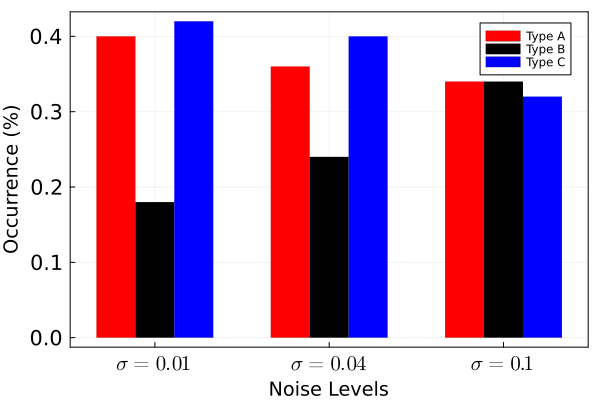

In [52]:


ctg = repeat(["Type A","Type B","Type C"], inner = 3)
nam = repeat([L"\sigma=0.1",L"\sigma=0.04",L"\sigma=0.01"], outer = 3)
Colour_Bars = repeat([:red,:black,:blue], inner = 3)
ada = plot(titlefontsize=16,
        guidefontsize=13,
        tickfontsize=14,
        legendfontsize=8,yminorgridlines=9)

ada = groupedbar!(nam, Prevalance, group = ctg, xlabel = "Noise Levels", ylabel = "Occurrence (%)", c=Colour_Bars,
         bar_width = 0.67,
        lw = 0, framestyle = :box)
savefig(ada,"Plots_Paper/ABC_Statistics_50Networks.png")
display(ada)